# Forecasting Retail Drug Store Sales - Time Series Analysis 

### Abstract:

- Forecasting sales is a critical task for retail operations like Rossmann, which operates over 3,000 drug stores across Europe. Accurate predictions enable proactive planning of inventory, staffing, and promotional activities.
- This project explores the application of various univariate and multivariate time series forecasting models to predict Rossmann store sales up to six weeks in advance.
- The dataset includes historical sales data alongside factors such as promotions, competition, holidays, and seasonal trends. Methods evaluated include simple models like averages and naive approaches, as well as advanced techniques like ARIMA, SARIMA, Prophet, and ARIMAX.
- Each model is assessed based on accuracy metrics such as Root Mean Squared PercentageError (RMSE). Results and insights from model comparisons guide recommendations for selecting optimal forecasting strategies tailored to Rossmann's operational dynamics.
- This study contributes to enhancing decision-making processes and operational efficiency in retail management through robust sales forecasting methodologies.


### Import Required Modules

In [65]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error
from statsforecast import StatsForecast
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothing, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, DynamicOptimizedTheta,AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings('ignore')

### Import Dataset

#### Splitting the data according to store Number

In [66]:
import pandas as pd

# Load data from CSV file into a DataFrame
data = pd.read_csv('train.csv', index_col="Date", low_memory=False, parse_dates=['Date'])

# Filter data for Store 1
data = data[data["Store"] == 1]

# Sort data by Date
data.sort_values(by="Date", inplace=True)

# Split data into training and testing sets
train_size = int(len(data) * 0.8)  # 80% for training
train_data = data[:train_size].copy()  # Copy first 80% for training
test_data = data[train_size:].copy()  # Copy remaining 20% for testing
test_data.tail() # Printing last 5  data of the test for checking

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-27      1          1   6102        612     1      1            0   
2015-07-28      1          2   5011        560     1      1            0   
2015-07-29      1          3   4782        523     1      1            0   
2015-07-30      1          4   5020        546     1      1            0   
2015-07-31      1          5   5263        555     1      1            0   

            SchoolHoliday  
Date                       
2015-07-27              1  
2015-07-28              1  
2015-07-29              1  
2015-07-30              1  
2015-07-31              1

### Data Preparation 

#### Data Statistics

In [67]:
# Display basic information about train_data
print("Train Data Info:")
train_data.info()

# Display summary statistics of numeric columns
print("\nSummary Statistics:")
print(train_data.describe())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          753 non-null    int64 
 1   DayOfWeek      753 non-null    int64 
 2   Sales          753 non-null    int64 
 3   Customers      753 non-null    int64 
 4   Open           753 non-null    int64 
 5   Promo          753 non-null    int64 
 6   StateHoliday   753 non-null    object
 7   SchoolHoliday  753 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 52.9+ KB

Summary Statistics:
       Store   DayOfWeek        Sales    Customers        Open       Promo  \
count  753.0  753.000000   753.000000   753.000000  753.000000  753.000000   
mean     1.0    3.997344  3996.416999   475.488712    0.830013    0.378486   
std      0.0    1.998003  2045.899537   232.848721    0.375871    0.485332   
min      1.0    1.000000     0.000000     0.00

In [68]:
# Display basic information about test_data
print("Test Data Info:")
test_data.info()

# Display summary statistics of numeric columns
print("\nSummary Statistics:")
print(test_data.describe())


Test Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2015-01-24 to 2015-07-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          189 non-null    int64 
 1   DayOfWeek      189 non-null    int64 
 2   Sales          189 non-null    int64 
 3   Customers      189 non-null    int64 
 4   Open           189 non-null    int64 
 5   Promo          189 non-null    int64 
 6   StateHoliday   189 non-null    object
 7   SchoolHoliday  189 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 13.3+ KB

Summary Statistics:
       Store   DayOfWeek        Sales   Customers        Open       Promo  \
count  189.0  189.000000   189.000000  189.000000  189.000000  189.000000   
mean     1.0    4.000000  3743.661376  436.402116    0.825397    0.396825   
std      0.0    2.005312  1880.689318  210.294088    0.380636    0.490539   
min      1.0    1.000000     0.000000    0.000000  

#### Checking for Null Values

In [69]:
# Count missing values in each column of train_data
missing_values_count = train_data.isnull().sum()

# Display the result
print("Missing Values in Train Data:")
print(missing_values_count)

train_data.drop(['Customers'],axis=1,inplace=True) #Removing Customers column as it not available in the testing data 


Missing Values in Train Data:
Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


#### Sorting  by date 

In [70]:
# Sort train_data by 'Date'
train_data.sort_values(by='Date', inplace=True)

# Display first few rows of sorted train_data
print("First few rows of sorted train_data:")
train_data.head()


First few rows of sorted train_data:


Store  DayOfWeek  Sales  Open  Promo StateHoliday  SchoolHoliday
Date                                                                        
2013-01-01      1          2      0     0      0            a              1
2013-01-02      1          3   5530     1      0            0              1
2013-01-03      1          4   4327     1      0            0              1
2013-01-04      1          5   4486     1      0            0              1
2013-01-05      1          6   4997     1      0            0              1

In [71]:
# Sort test_data by 'Date'
test_data.sort_values(by='Date', inplace=True)

# Display first few rows of sorted test_data
print("\nFirst few rows of sorted test_data:")
(test_data.head())



First few rows of sorted test_data:


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-01-24      1          6   4840        600     1      0            0   
2015-01-25      1          7      0          0     0      0            0   
2015-01-26      1          1   4781        566     1      1            0   
2015-01-27      1          2   4806        532     1      1            0   
2015-01-28      1          3   4310        537     1      1            0   

            SchoolHoliday  
Date                       
2015-01-24              0  
2015-01-25              0  
2015-01-26              0  
2015-01-27              0  
2015-01-28              0

### EDA

#### Plot Sales (All train data)

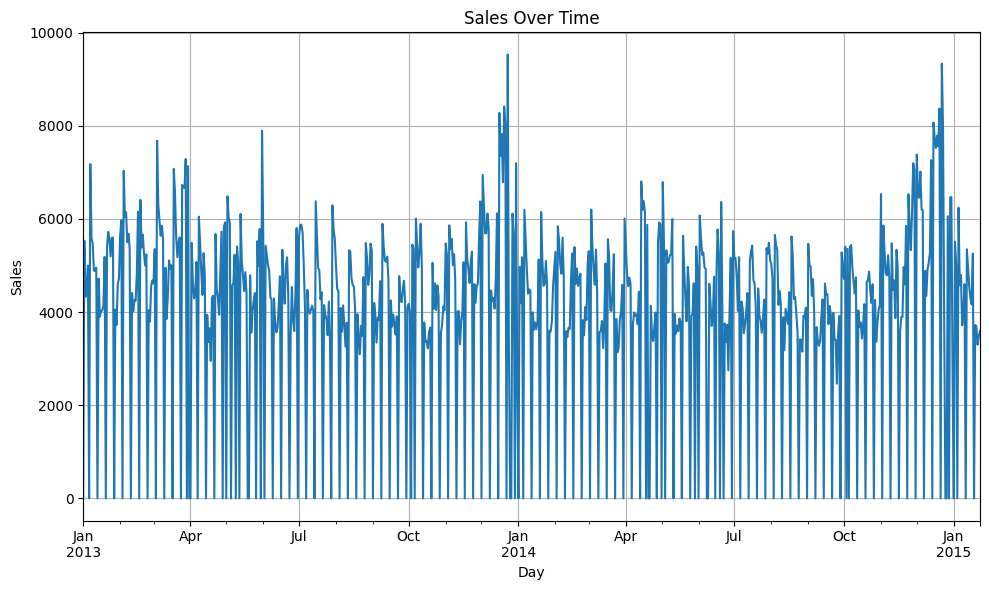

In [72]:
# Plotting Sales data over time
plt.figure(figsize=(10, 6))
train_data['Sales'].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)  # Adding grid lines for better readability
plt.tight_layout()  # Adjusting layout for better spacing
plt.show()

<Figure size 2000x1000 with 0 Axes>

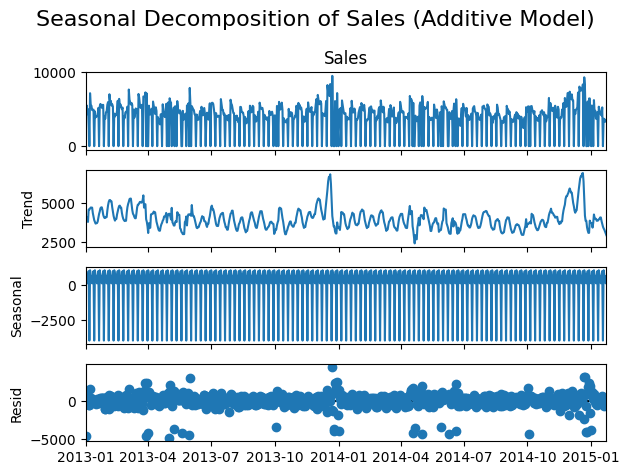

In [73]:
# Perform seasonal decomposition (additive model) on Sales data
result_add = seasonal_decompose(train_data['Sales'], model='additive', extrapolate_trend='freq')

# Plot the decomposed components (trend, seasonal, residual)
plt.figure(figsize=(20, 10))
result_add.plot()
plt.suptitle('Seasonal Decomposition of Sales (Additive Model)', fontsize=16)
plt.tight_layout()
plt.show()

#### Plot Sales (One Month)

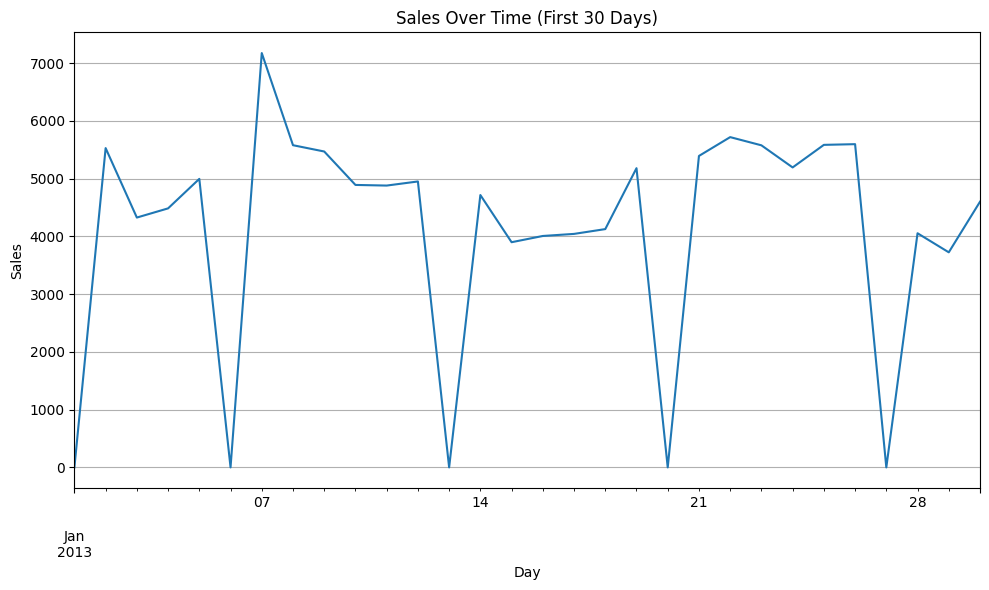

In [74]:
import matplotlib.pyplot as plt

# Plotting sales data for the first 30 days
plt.figure(figsize=(10, 6))
train_data['Sales'][:30].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales Over Time (First 30 Days)')
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


#### Insight: This plot providing a visual representation of sales data,  to identify trends, patterns, and fluctuations over time.



#### Plot Sales (One Year)

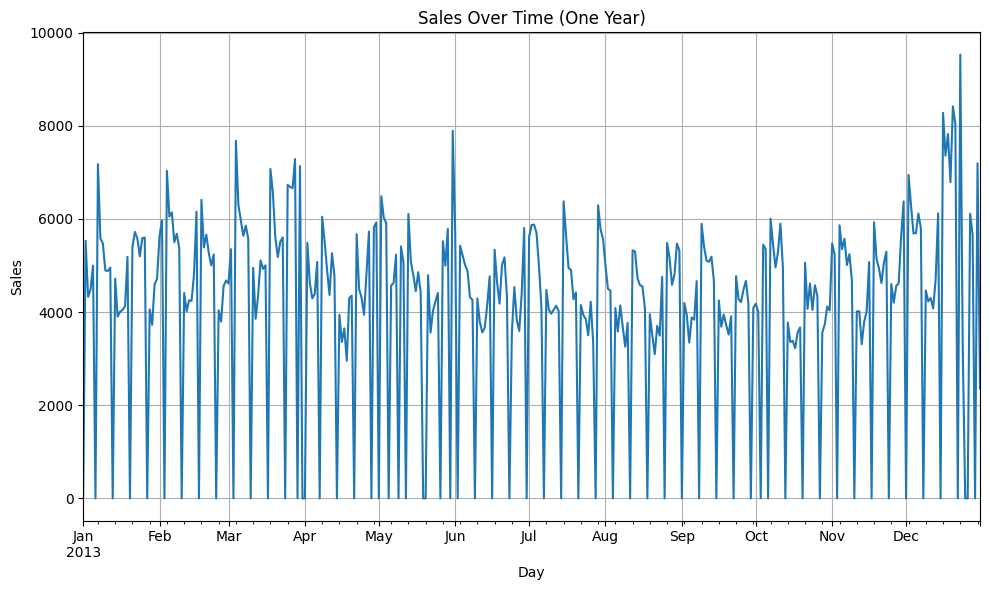

In [75]:
# Plotting sales data for the first 365 days (one year)
plt.figure(figsize=(10, 6))
train_data['Sales'][:365].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales Over Time (One Year)')
plt.grid(True)  # Adding grid lines for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


Insight : To identify tren, seasonality and pattern 

#### Extracting additional columns

In [76]:
# Extract year, month, and day from the index
train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['Day'] = train_data.index.day

# Convert the extracted components to integers
train_data['Year'] = train_data['Year'].astype(int)
train_data['Month'] = train_data['Month'].astype(int)
train_data['Day'] = train_data['Day'].astype(int)

# Display information about the train_data DataFrame
train_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          753 non-null    int64 
 1   DayOfWeek      753 non-null    int64 
 2   Sales          753 non-null    int64 
 3   Open           753 non-null    int64 
 4   Promo          753 non-null    int64 
 5   StateHoliday   753 non-null    object
 6   SchoolHoliday  753 non-null    int64 
 7   Year           753 non-null    int32 
 8   Month          753 non-null    int32 
 9   Day            753 non-null    int32 
dtypes: int32(3), int64(6), object(1)
memory usage: 55.9+ KB


#### Plot sales by different dates values

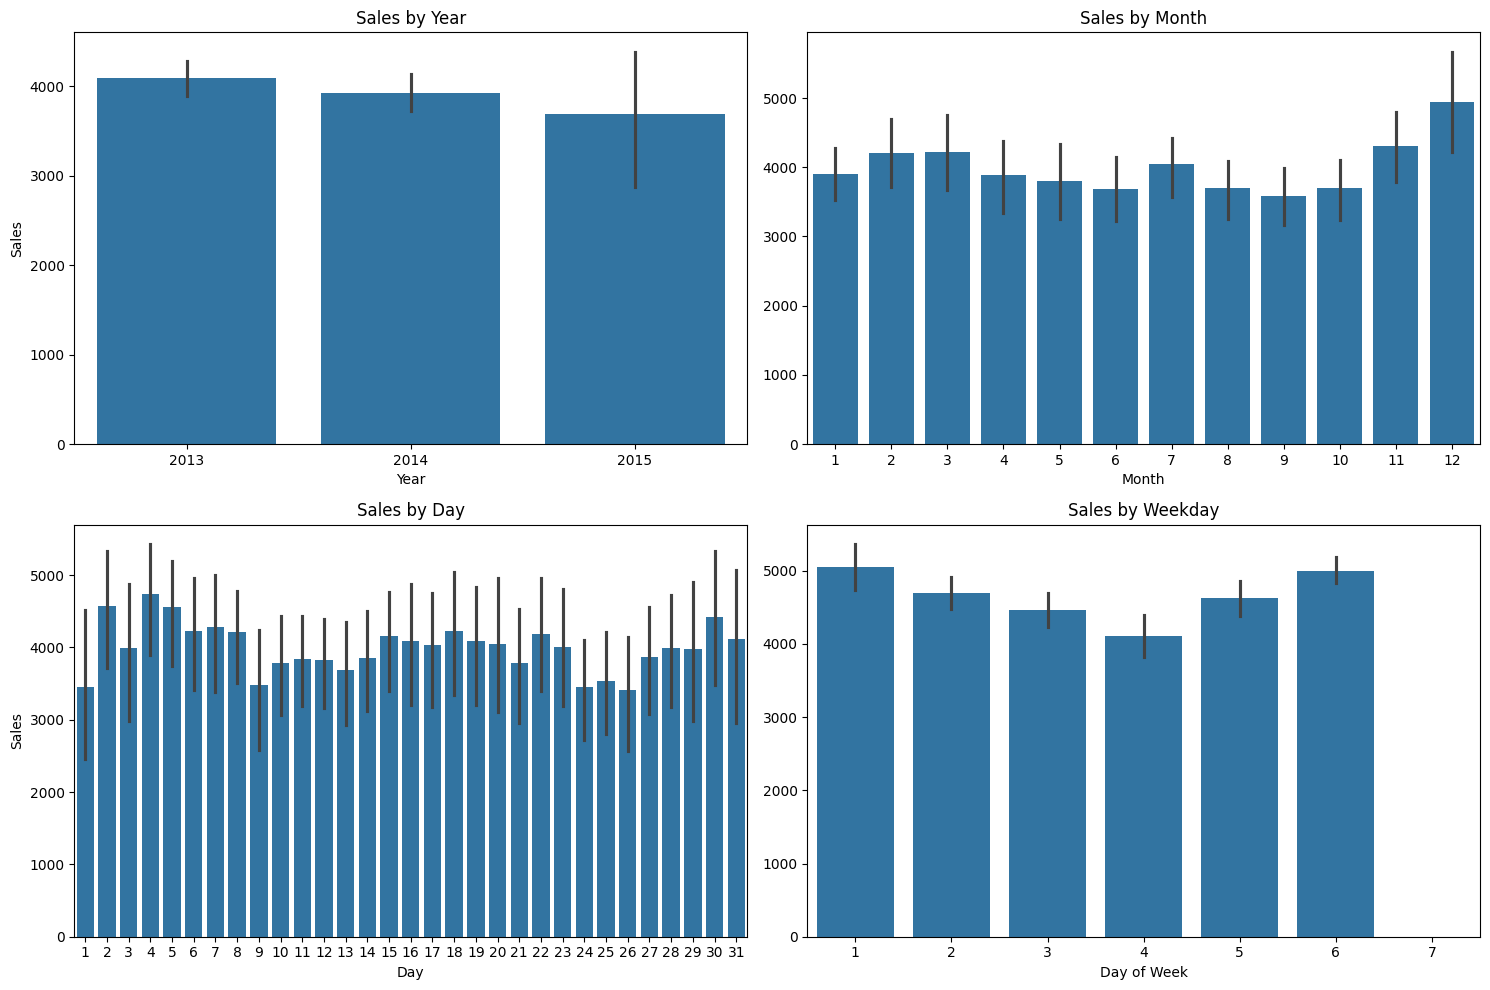

In [77]:
# Create grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bar plot for Sales by Year
sns.barplot(x='Year', y='Sales', data=train_data, ax=axes[0, 0])
axes[0, 0].set_title('Sales by Year')  # Set title for the subplot
axes[0, 0].set_xlabel('Year')  # Label x-axis
axes[0, 0].set_ylabel('Sales')  # Label y-axis

# Bar plot for Sales by Month
sns.barplot(x='Month', y='Sales', data=train_data, ax=axes[0, 1])
axes[0, 1].set_title('Sales by Month')  # Set title for the subplot
axes[0, 1].set_xlabel('Month')  # Label x-axis
axes[0, 1].set_ylabel('')  # Clear y-axis label for better readability

# Bar plot for Sales by Day
sns.barplot(x='Day', y='Sales', data=train_data, ax=axes[1, 0])
axes[1, 0].set_title('Sales by Day')  # Set title for the subplot
axes[1, 0].set_xlabel('Day')  # Label x-axis
axes[1, 0].set_ylabel('Sales')  # Label y-axis

# Bar plot for Sales by Day of Week
sns.barplot(x='DayOfWeek', y='Sales', data=train_data, ax=axes[1, 1])
axes[1, 1].set_title('Sales by Weekday')  # Set title for the subplot
axes[1, 1].set_xlabel('Day of Week')  # Label x-axis
axes[1, 1].set_ylabel('')  # Clear y-axis label for better readability

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

#### Plot sales by different dates values to get sum of Sales

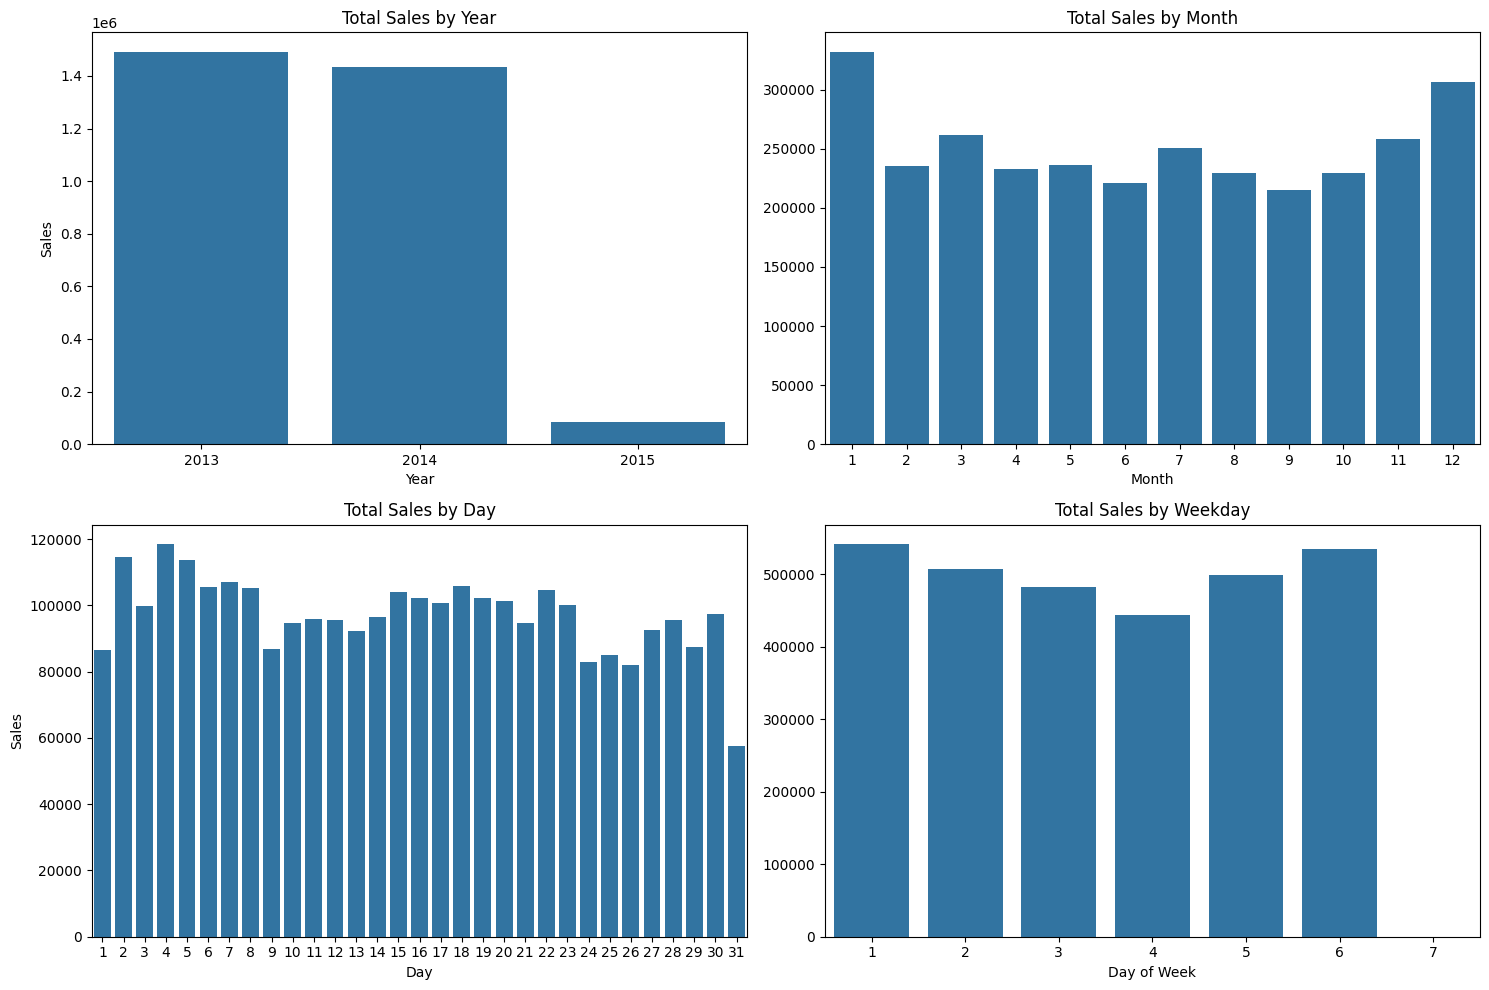

In [78]:
# Aggregate the data to get the sum of 'Sales' for each category
train_data_agg_year = train_data.groupby('Year')['Sales'].sum().reset_index()
train_data_agg_month = train_data.groupby('Month')['Sales'].sum().reset_index()
train_data_agg_day = train_data.groupby('Day')['Sales'].sum().reset_index()
train_data_agg_dayofweek = train_data.groupby('DayOfWeek')['Sales'].sum().reset_index()

# Create grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bar plot for Total Sales by Year
sns.barplot(x='Year', y='Sales', data=train_data_agg_year, ax=axes[0, 0])
axes[0, 0].set_title('Total Sales by Year')  # Set title for the subplot
axes[0, 0].set_xlabel('Year')  # Label x-axis
axes[0, 0].set_ylabel('Sales')  # Label y-axis

# Bar plot for Total Sales by Month
sns.barplot(x='Month', y='Sales', data=train_data_agg_month, ax=axes[0, 1])
axes[0, 1].set_title('Total Sales by Month')  # Set title for the subplot
axes[0, 1].set_xlabel('Month')  # Label x-axis
axes[0, 1].set_ylabel('')  # Clear y-axis label for better readability

# Bar plot for Total Sales by Day
sns.barplot(x='Day', y='Sales', data=train_data_agg_day, ax=axes[1, 0])
axes[1, 0].set_title('Total Sales by Day')  # Set title for the subplot
axes[1, 0].set_xlabel('Day')  # Label x-axis
axes[1, 0].set_ylabel('Sales')  # Label y-axis

# Bar plot for Total Sales by Day of Week
sns.barplot(x='DayOfWeek', y='Sales', data=train_data_agg_dayofweek, ax=axes[1, 1])
axes[1, 1].set_title('Total Sales by Weekday')  # Set title for the subplot
axes[1, 1].set_xlabel('Day of Week')  # Label x-axis
axes[1, 1].set_ylabel('')  # Clear y-axis label for better readability

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


#### Insights from Data

**The Insighst we gained:**

1. Sales decrease over the years

2. The peak of sales is on Nov and Dec

3. Sales increase in the opening and closing day of the week

#### Define Monthly Plot

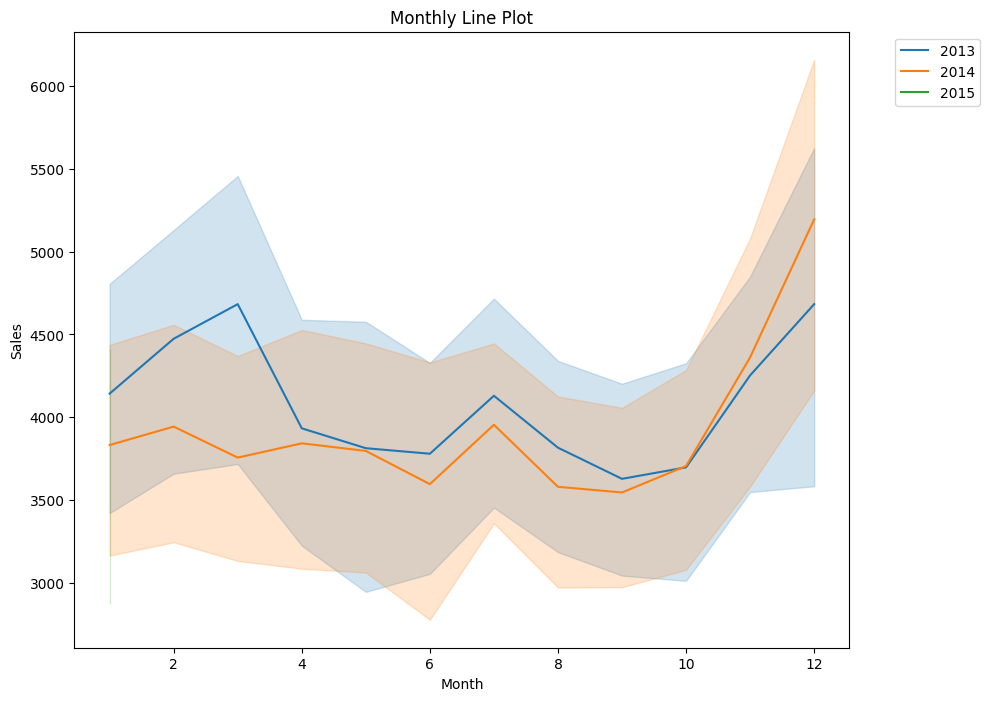

In [79]:
def monthly_line_plot(df, col_x, col_y, hue_col, title='Monthly'):
    """
    Plot a monthly line plot with seaborn.

    Parameters:
    - df: DataFrame containing the data.
    - col_x: Column name for the x-axis (typically month or time).
    - col_y: Column name for the y-axis (typically the value to plot over time).
    - hue_col: Column name for categorical differentiation (optional).
    - title: Title for the plot (default is 'Monthly').

    Returns:
    - None
    """
    plt.figure(figsize=(10, 8))
    sns.lineplot(data=df,
                 x=col_x,
                 y=col_y,
                 hue=hue_col,
                 legend='full', palette='tab10')
    plt.title(title + ' Line Plot')  # Set title for the plot
    plt.xlabel(col_x)  # Label x-axis
    plt.ylabel(col_y)  # Label y-axis
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

    # Show the plot
    plt.show()

monthly_line_plot(train_data,"Month","Sales","Year",title="Monthly")

#### Plot sales in different conditions

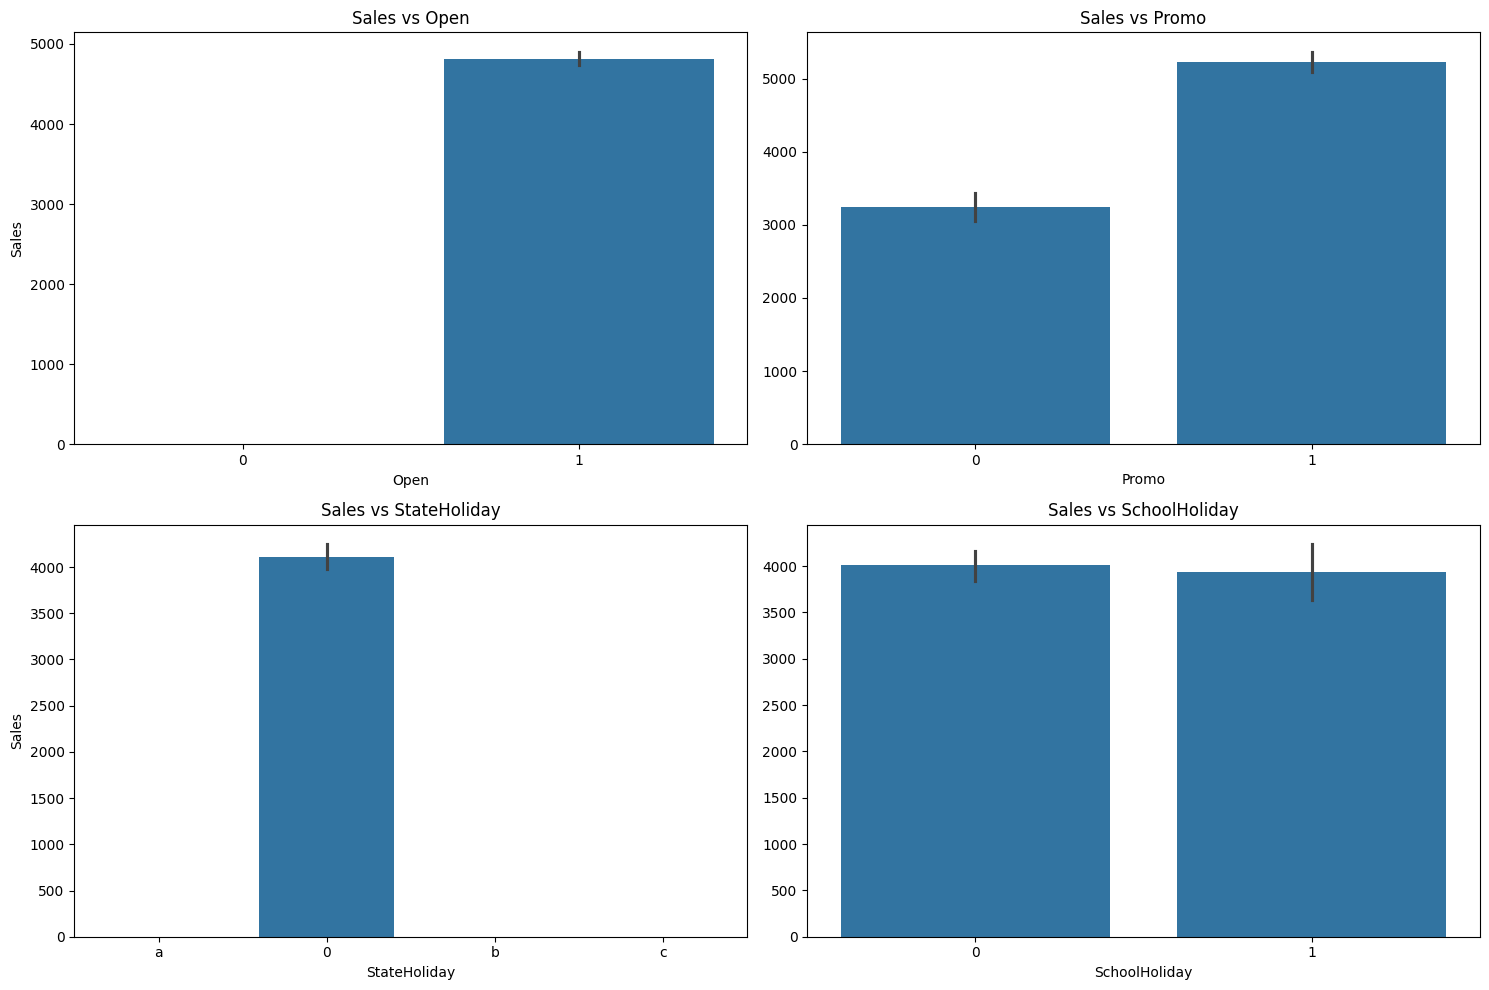

In [80]:
# Create grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bar plot for Sales vs Open
sns.barplot(x='Open', y='Sales', data=train_data, ax=axes[0, 0])
axes[0, 0].set_title('Sales vs Open')  # Set title for the subplot
axes[0, 0].set_xlabel('Open')  # Label x-axis
axes[0, 0].set_ylabel('Sales')  # Label y-axis

# Bar plot for Sales vs Promo
sns.barplot(x='Promo', y='Sales', data=train_data, ax=axes[0, 1])
axes[0, 1].set_title('Sales vs Promo')  # Set title for the subplot
axes[0, 1].set_xlabel('Promo')  # Label x-axis
axes[0, 1].set_ylabel('')  # Clear y-axis label for better readability

# Bar plot for Sales vs StateHoliday
sns.barplot(x='StateHoliday', y='Sales', data=train_data, ax=axes[1, 0])
axes[1, 0].set_title('Sales vs StateHoliday')  # Set title for the subplot
axes[1, 0].set_xlabel('StateHoliday')  # Label x-axis
axes[1, 0].set_ylabel('Sales')  # Label y-axis

# Bar plot for Sales vs SchoolHoliday
sns.barplot(x='SchoolHoliday', y='Sales', data=train_data, ax=axes[1, 1])
axes[1, 1].set_title('Sales vs SchoolHoliday')  # Set title for the subplot
axes[1, 1].set_xlabel('SchoolHoliday')  # Label x-axis
axes[1, 1].set_ylabel('')  # Clear y-axis label for better readability

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


**Nothing unusual, no sales when store is closed, State holidays don't add new information, sales increase in promo, and Shool holidays don't make that difference**

### Evaluation Metric : RMSPE

RMSPE is chosen because it measures prediction accuracy in percentage terms relative to the actual values. This metric is valuable for understanding how well predictions match real-world outcomes, especially in contexts like sales forecasting where knowing the percentage error can directly impact decision-making and planning. It provides a standardized way to evaluate models that is both interpretable and robust across different scales of data, making it a practical choice in many forecasting and predictive modeling scenarios.

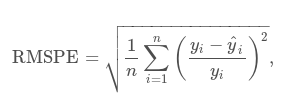

In [81]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rmspe(y_true, y_pred):
    """
    Calculate the Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true: Array-like of true values.
    - y_pred: Array-like of predicted values.

    Returns:
    - rmspe_score: RMSPE value.
    """
    # Ensure arrays are numpy arrays for calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate RMSPE
    rmspe_score = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
    
    return rmspe_score


#### Plot train vs test

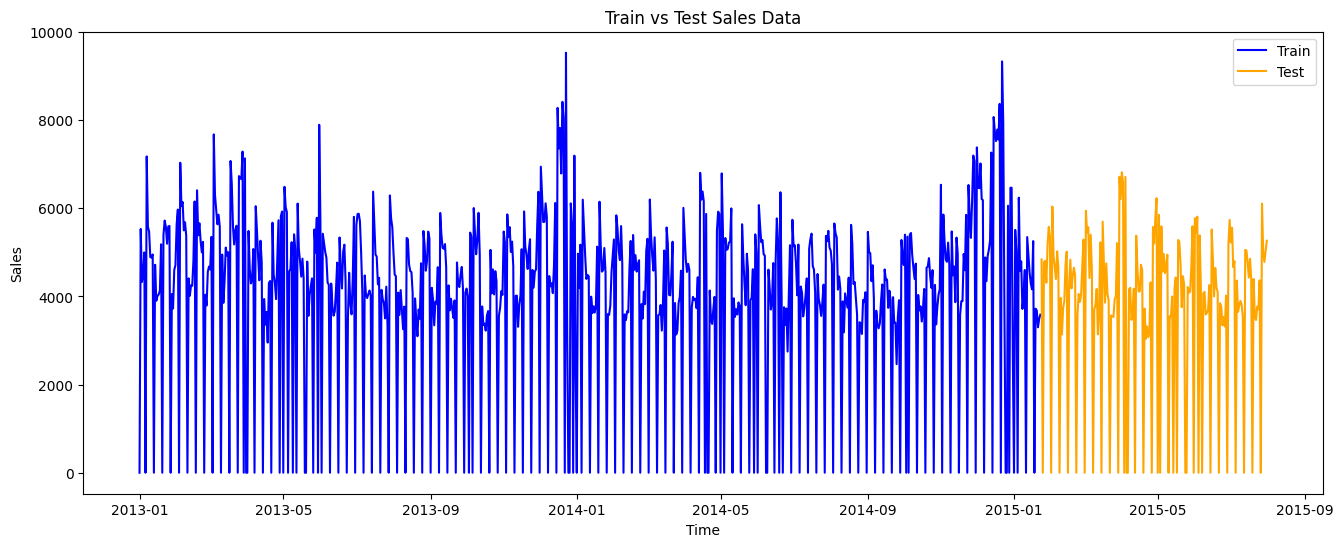

In [82]:
# Create figure and axes
fig, axes = plt.subplots(1, 1, figsize=(16, 6))  # Set figure size

# Plot train and test data
axes.plot(train_data["Sales"], label='Train', color='blue')  # Plot train data
axes.plot(test_data["Sales"], label='Test', color='orange')  # Plot test data

# Set plot labels and title
axes.set_xlabel('Time')  # Label x-axis
axes.set_ylabel('Sales')  # Label y-axis
axes.set_title('Train vs Test Sales Data')  # Set title
axes.legend()  # Show legend

# Show plot
plt.show()


## Forecasting Models

### Univariate forecasting Models

In [83]:
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothingOptimized, Holt, DynamicOptimizedTheta

# Initialize empty list to store models
models = []

# Add models to the list
models.append(HistoricAverage(alias="Average"))  # Historic Average model
models.append(Naive(alias="Naive"))  # Naive model
models.append(RandomWalkWithDrift(alias="Drift"))  # Random Walk with Drift model
models.append(SeasonalNaive(season_length=7, alias="Seasonal Naive"))  # Seasonal Naive model
models.append(SimpleExponentialSmoothingOptimized(alias="SESOpt"))  # Simple Exponential Smoothing Optimized model
models.append(Holt(alias="Holt"))  # Holt's Model or Double Exponential Smoothing
models.append(DynamicOptimizedTheta(season_length=12, decomposition_type="additive", alias="Theta"))  # Theta Model

# Print the list of models
print(models)


[Average, Naive, Drift, Seasonal Naive, SESOpt, Holt, Theta]


#### Renaming columns according to Data

In [84]:
# Reset index to include "Date" as a column
train_data = train_data.reset_index()

traindata = pd.DataFrame(train_data)

# Create a new DataFrame traindata with selected columns
traindata = train_data[["Date", "Sales", "Open", "Promo", "SchoolHoliday"]]

# Add a unique_id column (assuming all rows have the same unique_id)
traindata["unique_id"] = 1

# Rename columns to match the expected format
traindata.columns = ["ds", "y", "Open", "Promo", "SchoolHoliday", "unique_id"]

# Display the first few rows of traindata
traindata.head()

ds     y  Open  Promo  SchoolHoliday  unique_id
0 2013-01-01     0     0      0              1          1
1 2013-01-02  5530     1      0              1          1
2 2013-01-03  4327     1      0              1          1
3 2013-01-04  4486     1      0              1          1
4 2013-01-05  4997     1      0              1          1

In [85]:
# Reset index to include "Date" as a column
test_data = test_data.reset_index()

testdata = pd.DataFrame(test_data)

# Create a new DataFrame testdata with selected columns
testdata = test_data[["Date", "Sales"]]

# Rename columns to match the expected format
testdata.columns = ["ds", "y"]

# Display the first few rows of testdata
testdata.head()

ds     y
0 2015-01-24  4840
1 2015-01-25     0
2 2015-01-26  4781
3 2015-01-27  4806
4 2015-01-28  4310

#### Initialising a new StatsForecast object with the parameters

In [86]:
# Initialize StatsForecast object
sf = StatsForecast(df=traindata,  # Pass the training data DataFrame
                   models=models,  # List of models to fit
                   freq='D',      # Specify daily frequency ('D')
                   n_jobs=-1)     # Use all available CPUs for fitting models

# Fit the models to the training data
sf.fit()

# Access fitted models and their results
fitted_models = sf.fitted_

# Print or use fitted_models as needed
print(fitted_models)

[[Average Naive Drift Seasonal Naive SESOpt Holt Theta]]


#### Fitted values from the models

In [87]:
# Access fitted models for each specific model type
result_avg = sf.fitted_[0,0].model_  # Historic Average model
result_naive = sf.fitted_[0,1].model_  # Naive model
result_drift = sf.fitted_[0,2].model_  # Random Walk with Drift model
result_snaive = sf.fitted_[0,3].model_  # Seasonal Naive model
result_sesopt = sf.fitted_[0,4].model_  # Simple Exponential Smoothing Optimized model
result_holt = sf.fitted_[0,5].model_  # Holt's Model (Double Exponential Smoothing)
result_theta = sf.fitted_[0,6].model_  # Theta model

In [88]:
#Extract only fitted values from the models into a dataframe
fitted_df = pd.DataFrame()

# Extract fitted values from each model and add to fitted_df
fitted_df["fitted_avg"] = result_avg.get("fitted")
fitted_df["fitted_naive"] = result_naive.get("fitted")
fitted_df["fitted_drift"] = result_drift.get("fitted")
fitted_df["fitted_snaive"] = result_snaive.get("fitted")
fitted_df["fitted_sesopt"] = result_sesopt.get("fitted")
fitted_df["fitted_holt"] = result_holt.get("fitted")
fitted_df["fitted_theta"] = result_theta.get("fitted")

#Also have the timestamp
fitted_df["ds"]=traindata["ds"]

# Display the fitted DataFrame
fitted_df.head()

fitted_avg  fitted_naive  fitted_drift  fitted_snaive  fitted_sesopt  \
0  3996.416992           NaN           NaN            NaN            NaN   
1  3996.416992           0.0      4.768617            NaN       0.000000   
2  3996.416992        5530.0   5534.768555            NaN     371.107574   
3  3996.416992        4327.0   4331.768555            NaN     636.579834   
4  3996.416992        4486.0   4490.768555            NaN     894.906982   

   fitted_holt  fitted_theta         ds  
0  4593.641113      0.000000 2013-01-01  
1  4580.247559      0.000000 2013-01-02  
2  4567.812012   5437.719238 2013-01-03  
3  4555.478027   4036.473633 2013-01-04  
4  4543.406250   3778.310059 2013-01-05

#### Plot Actual vs Fitted models

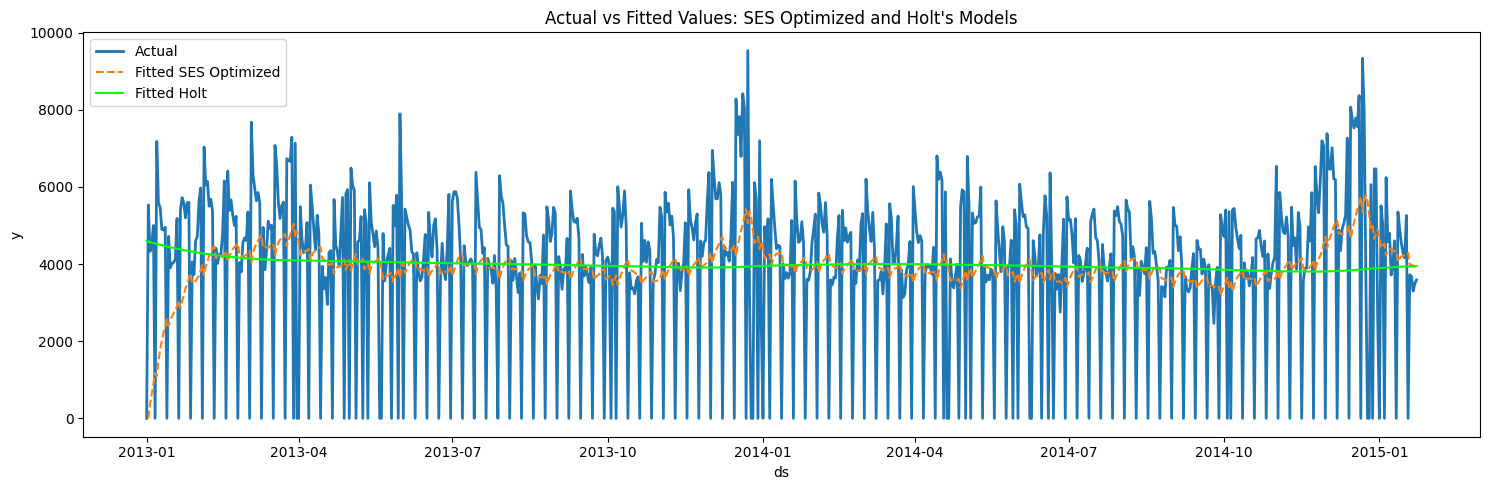

In [89]:
# Create a figure and set its size
plt.figure(figsize=(15, 5))

# Plot actual data
sns.lineplot(data=traindata, x="ds", y="y", label="Actual", linewidth=2)

# Plot SES Optimized model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_sesopt", label="Fitted SES Optimized", linestyle="--")

# Plot Holt's model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_holt", label="Fitted Holt", color="lime")

# Set title and adjust layout
plt.title("Actual vs Fitted Values: SES Optimized and Holt's Models")
plt.tight_layout()
plt.show()

#### Forecast using the models

In [90]:
#The forecast period
horizon=len(testdata)

# Forecast for the given horizon length using fitted models
Y_hat = sf.forecast(h=horizon, fitted=True)

#Resetting the index
Y_hat=Y_hat.reset_index()

# Display the first few rows of the forecasted values
Y_hat.head()

unique_id         ds      Average   Naive        Drift  Seasonal Naive  \
0          1 2015-01-24  3996.416992  3586.0  3590.768555          5255.0   
1          1 2015-01-25  3996.416992  3586.0  3595.537354             0.0   
2          1 2015-01-26  3996.416992  3586.0  3600.305908          3721.0   
3          1 2015-01-27  3996.416992  3586.0  3605.074463          3680.0   
4          1 2015-01-28  3996.416992  3586.0  3609.843018          3299.0   

       SESOpt         Holt        Theta  
0  3868.49292  3948.767334  3700.276123  
1  3868.49292  3950.299316  3700.164062  
2  3868.49292  3951.800293  3700.051270  
3  3868.49292  3953.270752  3699.937500  
4  3868.49292  3954.711182  3699.822510

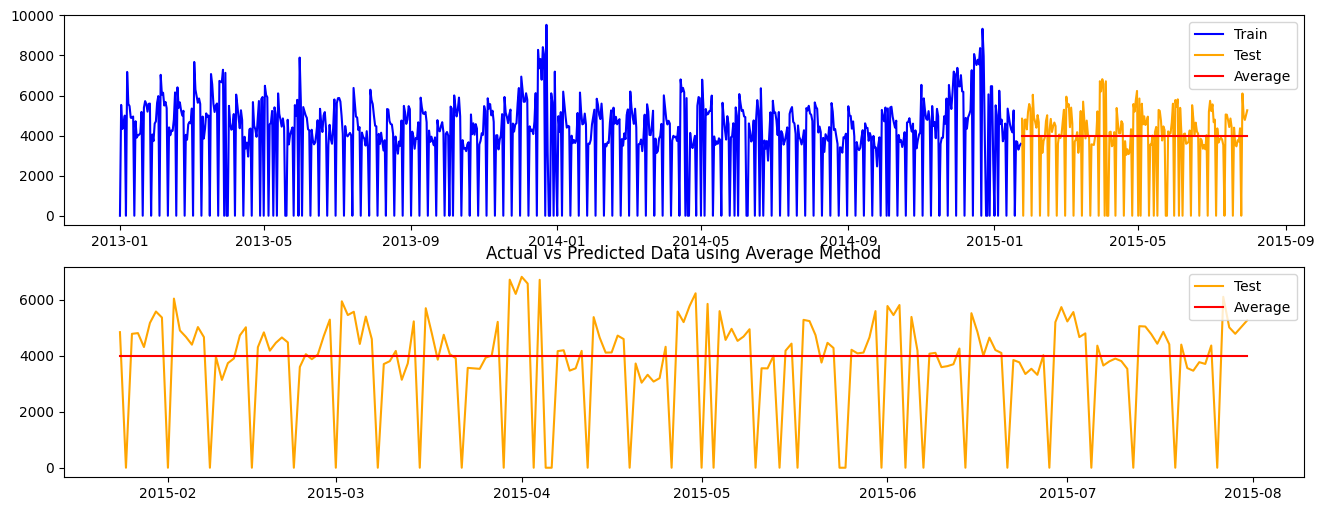

In [91]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['Average'],label="Average",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['Average'],label="Average",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using Average Method')
plt.show()

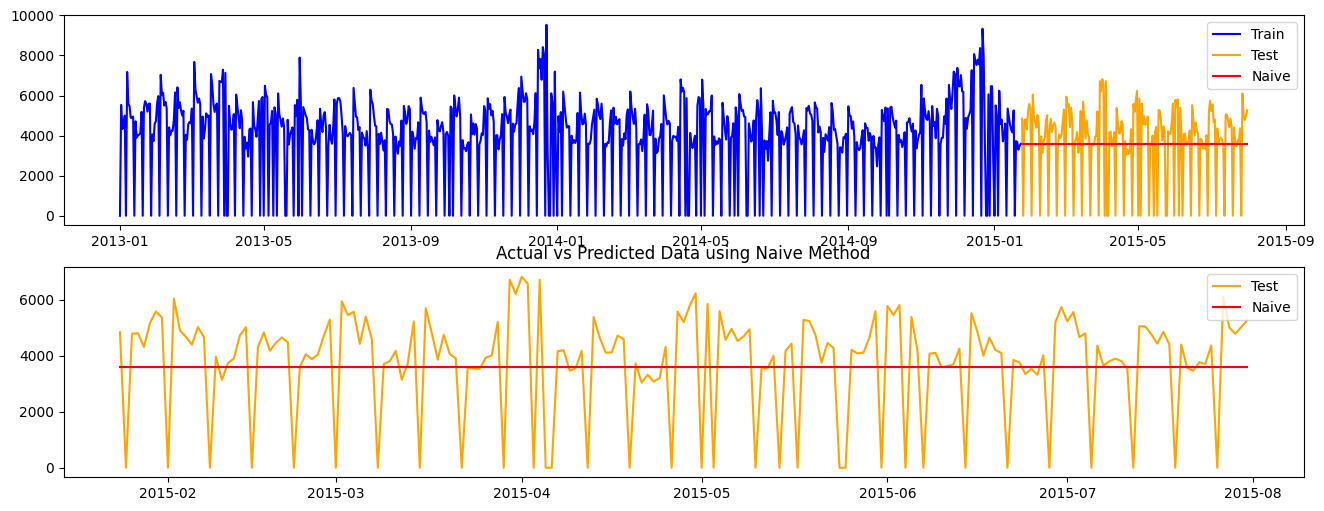

In [92]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['Naive'],label="Naive",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['Naive'],label="Naive",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using Naive Method')
plt.show()

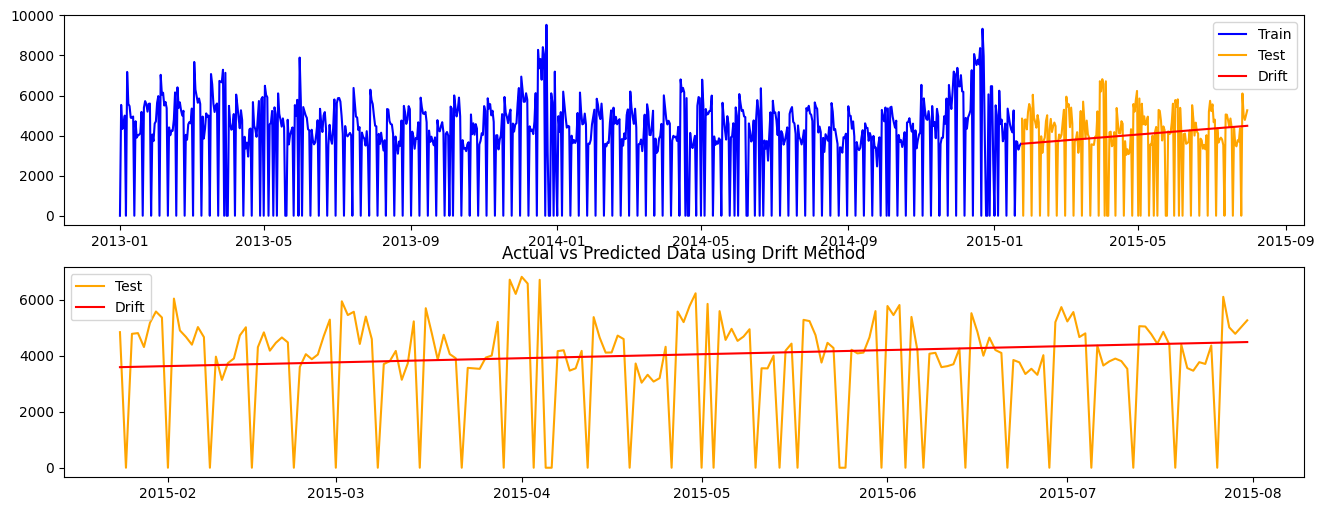

In [93]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['Drift'],label="Drift",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['Drift'],label="Drift",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using Drift Method')
plt.show()

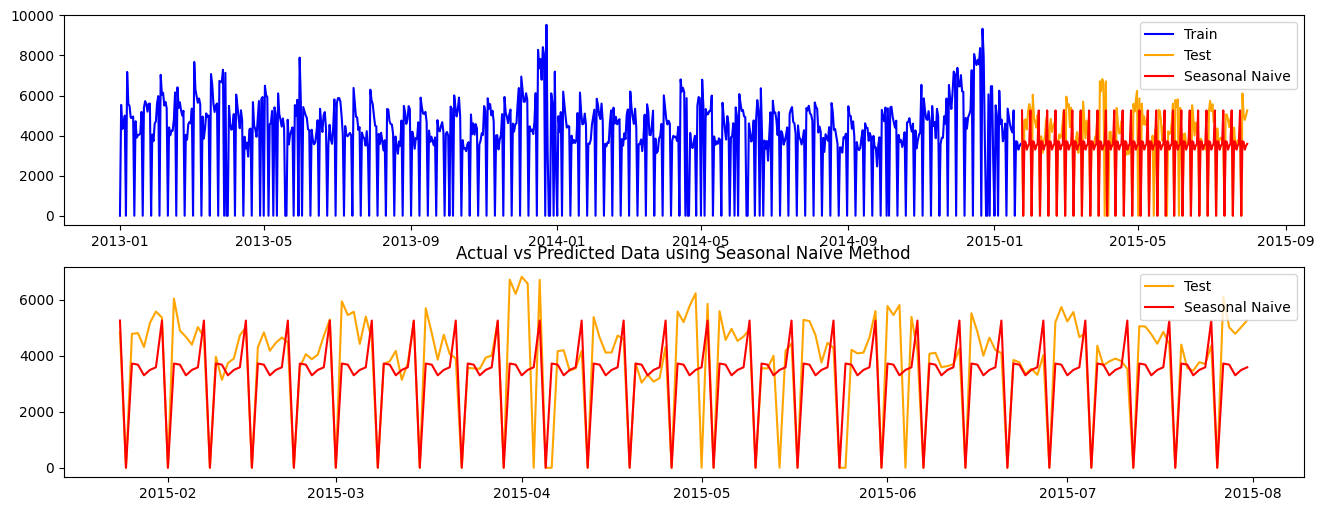

In [94]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['Seasonal Naive'],label="Seasonal Naive",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['Seasonal Naive'],label="Seasonal Naive",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using Seasonal Naive Method')
plt.show()

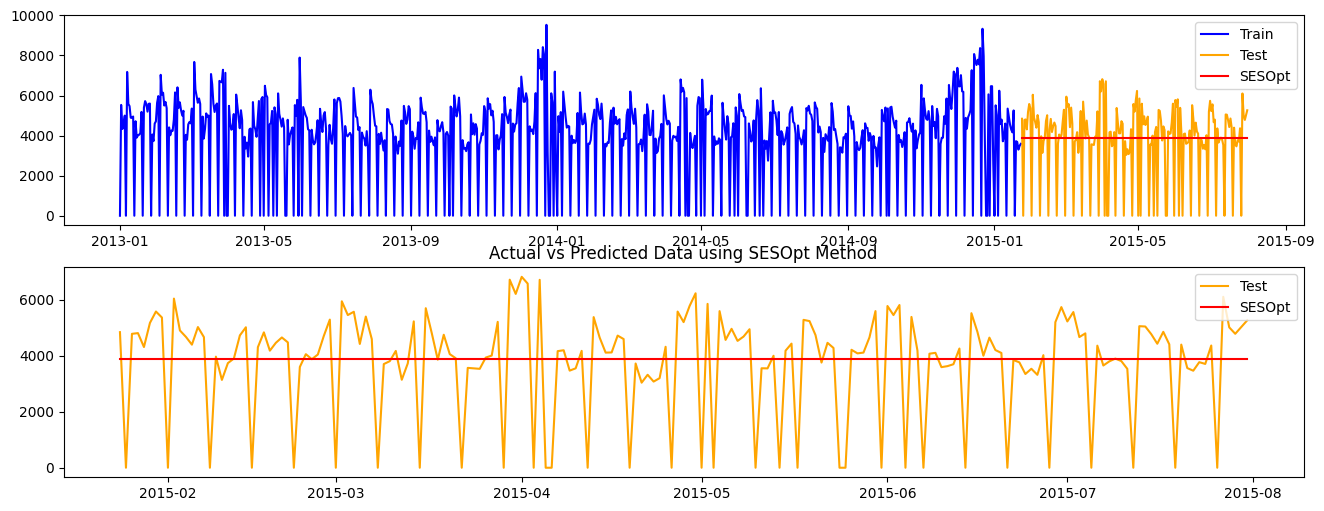

In [95]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['SESOpt'],label="SESOpt",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['SESOpt'],label="SESOpt",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using SESOpt Method')
plt.show()

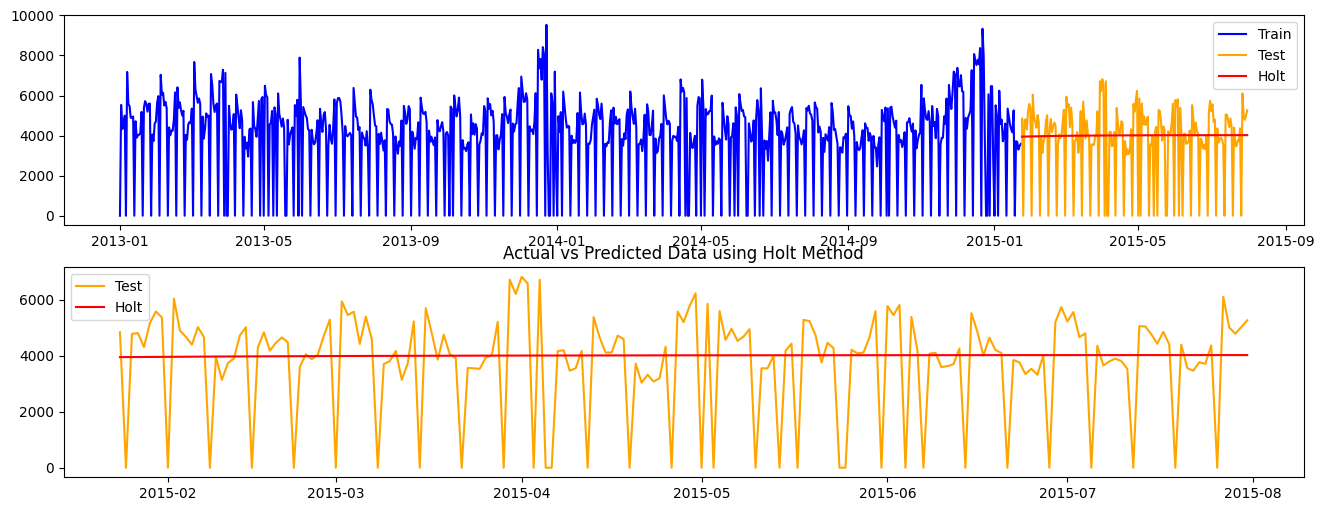

In [96]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['Holt'],label="Holt",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['Holt'],label="Holt",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using Holt Method')
plt.show()

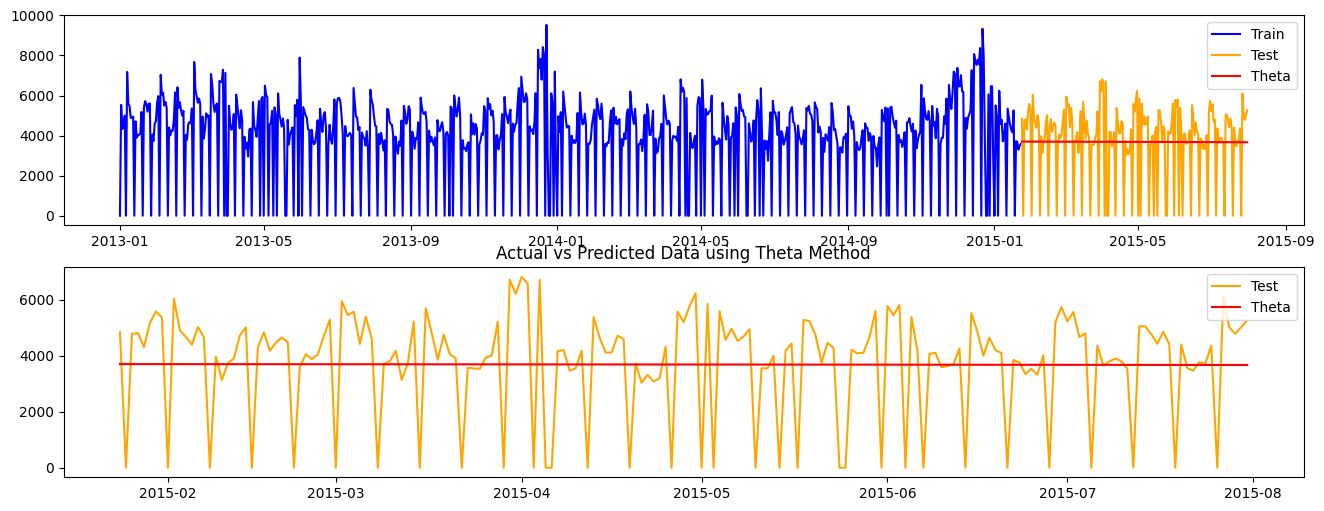

In [97]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(Y_hat['ds'],Y_hat['Theta'],label="Theta",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(Y_hat['ds'],Y_hat['Theta'],label="Theta",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted Data using Theta Method')
plt.show()

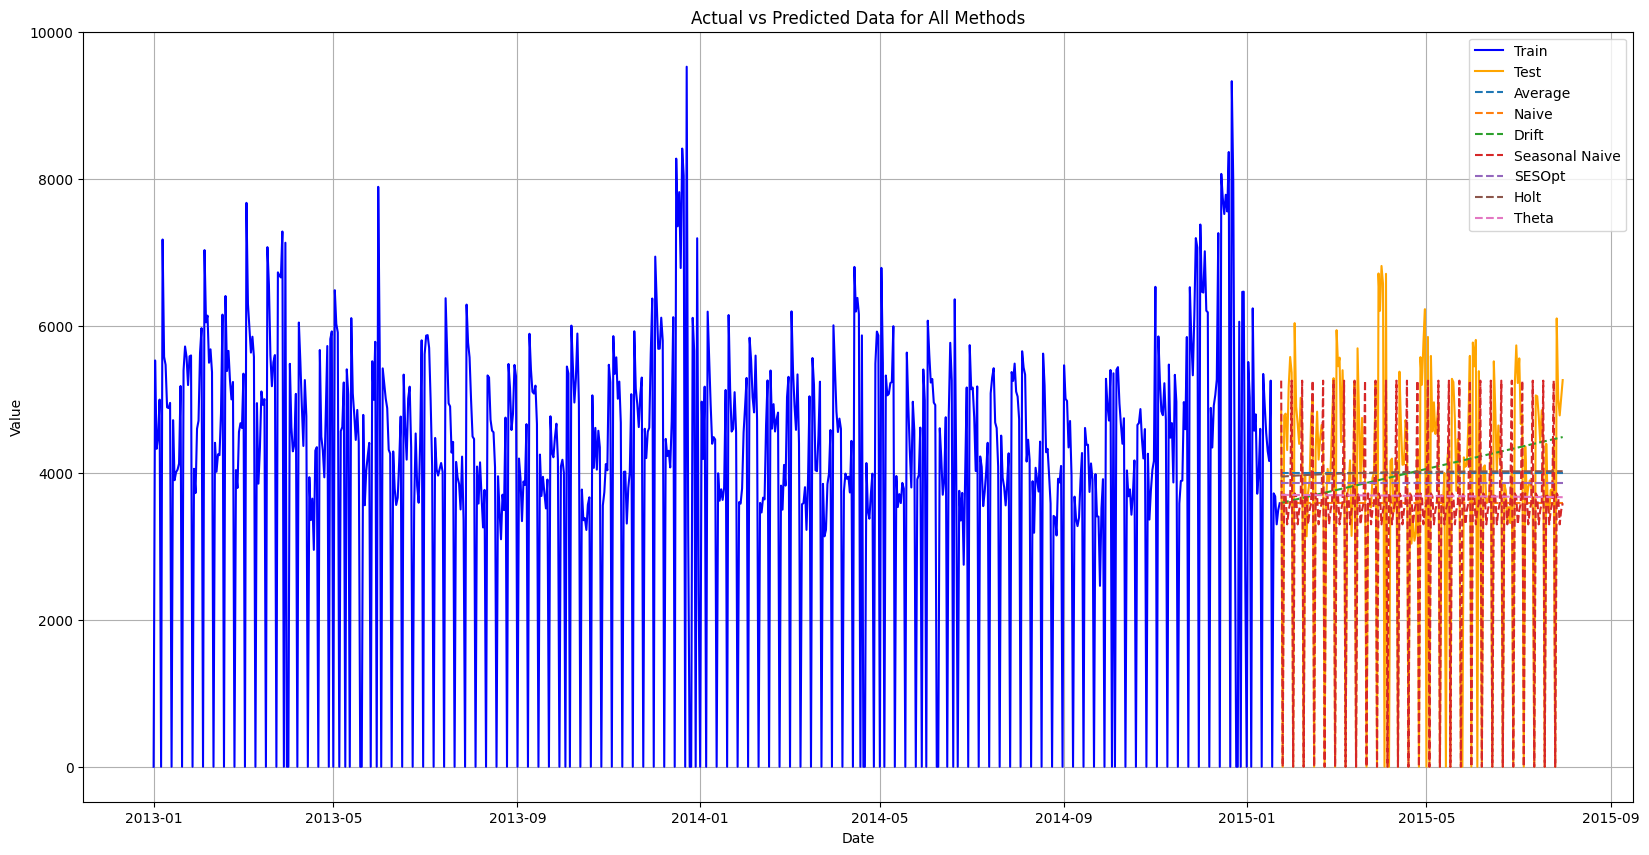

In [98]:
import matplotlib.pyplot as plt

# Assuming you have defined traindata, testdata, and Y_hat for each method
methods = ['Average', 'Naive', 'Drift', 'Seasonal Naive', 'SESOpt', 'Holt', 'Theta']

plt.figure(figsize=(20, 10))

# Plot training and test data
plt.plot(traindata["ds"], traindata["y"], label='Train', color='blue')
plt.plot(testdata["ds"], testdata["y"], label='Test', color='orange')

# Plot predictions for each method
for method in methods:
    plt.plot(Y_hat['ds'], Y_hat[method], label=method, linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data for All Methods')
plt.legend()
plt.grid(True)
plt.show()


#### Evaluate model performance

#### We are calculating error by using all methods i.e. MAE,MAPE,MSE,RMSE,RMSPE

In [99]:
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
#Get the actual 12 month values of forecast duration
actual_ts = testdata["y"]

#Create a list with the model aliases
model_names = [str(model) for model in models]

#Initialize error dataframe
error_df = pd.DataFrame(columns=model_names, index=["MAE","MAPE","MSE","RMSE","RMSPE"])

#Print the errors for each model
for model in model_names:
    
    #Evaluate the model MAE
    model_mae = np.round(mean_absolute_error(actual_ts, Y_hat[model]),2)
   
    #Evaluate the model MAPE
    model_mape = np.round(100*mean_absolute_percentage_error(actual_ts, Y_hat[model]),2)
    
    #Evaluate the model MSE
    model_mse = np.round(mean_squared_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model RMSE
    model_rmse = np.round(mean_squared_error(actual_ts, Y_hat[model],squared=False),2)
    
    model_rmspe=np.round(root_mean_squared_percentage_error(actual_ts, Y_hat[model]),2)
    #Save errors in error dataframe
    error_df.loc[:,model] = (model_mae, model_mape, model_mse, model_rmse,model_rmspe)

##### Print error values of all methods

In [100]:
error_df

Average                    Naive  \
MAE                    1320.66                   1449.3   
MAPE   314255369595492368384.0  281982525240089837568.0   
MSE                 3582163.47               3543135.17   
RMSE                   1892.66                  1882.32   
RMSPE                     0.51                      0.5   

                         Drift          Seasonal Naive  \
MAE                    1350.74                  902.46   
MAPE   317400788467493699584.0  51464944313199984640.0   
MSE                 3698466.55              1603907.02   
RMSE                   1923.14                 1266.45   
RMSPE                     0.51                    0.34   

                        SESOpt                     Holt  \
MAE                    1348.53                  1320.92   
MAPE   304196152379525627904.0  314993818475520065536.0   
MSE                 3533860.98               3590609.54   
RMSE                   1879.86                  1894.89   
RMSPE                      0.5                     0.51   

                         Theta  
MAE                     1407.0  
MAPE   289844194524043247616.0  
MSE                  3520971.1  
RMSE                   1876.43  
RMSPE                      0.5

#### Finding Best Model among all models

In [101]:
#Create a new column saying which method performed the best, for each evaluation metric
error_df['Best model'] = error_df.idxmin(axis=1)

In [102]:
#Show the error dataframe on the console
error_df

Average                    Naive  \
MAE                    1320.66                   1449.3   
MAPE   314255369595492368384.0  281982525240089837568.0   
MSE                 3582163.47               3543135.17   
RMSE                   1892.66                  1882.32   
RMSPE                     0.51                      0.5   

                         Drift          Seasonal Naive  \
MAE                    1350.74                  902.46   
MAPE   317400788467493699584.0  51464944313199984640.0   
MSE                 3698466.55              1603907.02   
RMSE                   1923.14                 1266.45   
RMSPE                     0.51                    0.34   

                        SESOpt                     Holt  \
MAE                    1348.53                  1320.92   
MAPE   304196152379525627904.0  314993818475520065536.0   
MSE                 3533860.98               3590609.54   
RMSE                   1879.86                  1894.89   
RMSPE                      0.5                     0.51   

                         Theta      Best model  
MAE                     1407.0  Seasonal Naive  
MAPE   289844194524043247616.0  Seasonal Naive  
MSE                  3520971.1  Seasonal Naive  
RMSE                   1876.43  Seasonal Naive  
RMSPE                      0.5  Seasonal Naive

#### As our evaluation metric is RMSPE, According to that sorting values

In [103]:
#Order the models in ascending order of RMSPE
error_df.loc["RMSPE",~error_df.columns.isin(["Best model"])].sort_values()

Seasonal Naive    0.34
Naive              0.5
SESOpt             0.5
Theta              0.5
Average           0.51
Drift             0.51
Holt              0.51
Name: RMSPE, dtype: object

**Seasonal Naive method is doing a very good job actually!**

### Multivariate Forecasting

#### Autocorrelation

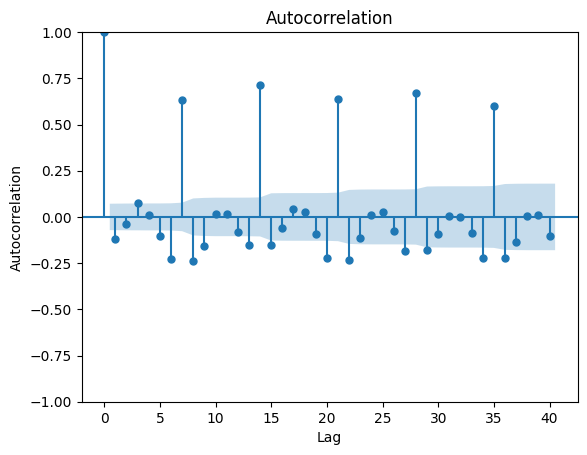

In [104]:
#Autocorrelation plot
plot_acf(traindata["y"], lags=40)
plt.ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.show()

#### Partial Autocorrelation

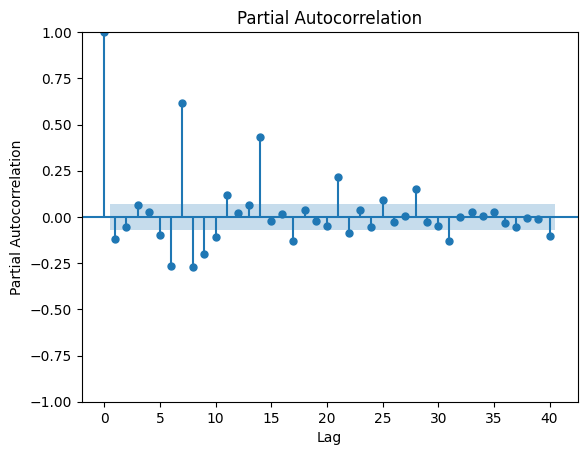

In [105]:
#Partial Autocorrelation plot
plot_pacf(traindata["y"], lags=40)
plt.ylabel("Partial Autocorrelation")
plt.xlabel("Lag")
plt.show()

**The ACF and PACF show a sine wave-like correlation pattern with high positive correlations at lag 7, 14, 21, and so on, it suggests the presence of a seasonal component in the data.**

#### Augmented Dickey Fuller test

In [106]:
#Augmented Dickey Fuller test
adftest = adfuller(traindata["y"])
adf_stat = adftest[0]
adf_pval = adftest[1]
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

stat = -3.627865, pval = 0.005250
The time series is stationary at a 5% significance level


#### KPSS Test

In [107]:
#KPSS test
kpsstest = kpss(traindata["y"])
kpss_stat = kpsstest[0]
kpss_pval = kpsstest[1]
#Check result
print("stat = %f, pval = %f" % (kpss_stat, kpss_pval))
#Final result
if kpss_pval > 0.05:
    print("The time series is stationary at a 5% significance level")
else:
    print("The time series is not stationary at a 5% significance level")

stat = 0.209959, pval = 0.100000
The time series is stationary at a 5% significance level


### ARIMA Model

##### Data preprocessing for Nixtla & Model Defining

In [108]:
#Simple data preprocessing for Nixtla
df_nix=pd.DataFrame()
df_nix = traindata[["ds","y","unique_id"]]
df_nix.head()
#Defining the models
models = [
    AutoARIMA()
]
sf = StatsForecast(df=df_nix,
                   models=models,
                   freq='D',  
                   n_jobs=-1,
                   fallback_model=SeasonalNaive(season_length=7))
sf.fit(df_nix)
model_params = sf.fitted_[0][0].model_
model_params

{'coef': {'ar1': 0.9999736134502522,
  'ma1': -1.1301536131241625,
  'ma2': 0.145242764344226},
 'sigma2': 4141795.792999101,
 'var_coef': array([[ 1.33384685e-13,  3.12942953e-09, -4.05850233e-09],
        [ 3.12942953e-09,  3.48408791e-04, -3.67260283e-04],
        [-4.05850233e-09, -3.67260283e-04,  4.14153216e-04]]),
 'mask': array([ True,  True,  True]),
 'loglik': -6806.127885712238,
 'aic': 13620.255771424476,
 'arma': (1, 2, 0, 0, 1, 0, 0),
 'residuals': array([    0.        ,  3862.24733058,  1789.67014412,  1316.20601056,
         1477.31548315, -3319.4136667 ,  3219.72279596,  2170.55164082,
         1713.46042324,   945.54591199,   755.8415649 ,   742.35996482,
        -4105.140016  ,    79.51908531,  -147.63840709,   -65.11258004,
          -14.95203589,    74.150852  ,  1117.93396305, -3876.46838822,
          896.03330879,  1850.23192896,  1771.17551472,  1314.66460558,
         1587.83947431,  1582.02214209, -4007.35503759,  -655.82432384,
         -484.81856475,   422.

#### Residual Analysis

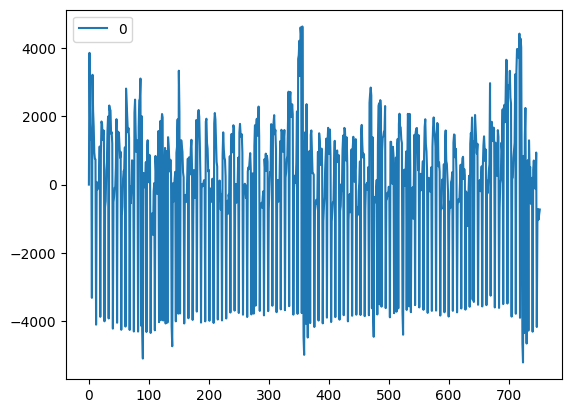

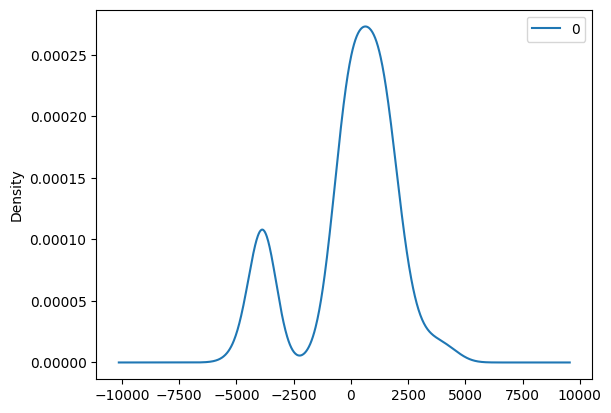

In [109]:
#Residual analysis
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

#### Statistics summary & Forecast

In [110]:
# Summary statistics of residuals
print(residuals.describe())
#Get forecast
arima_forecast = sf.forecast(h=189, level=[95])
arima_forecast

                 0
count   753.000000
mean     19.080151
std    2032.342452
min   -5214.175403
25%    -499.770427
50%     422.411721
75%    1324.323559
max    4635.525274


ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
unique_id                                                          
1         2015-01-24  4285.950195       297.148468      8274.751953
1         2015-01-25  4179.800293       157.341934      8202.258789
1         2015-01-26  4179.689941       156.782745      8202.597656
1         2015-01-27  4179.579590       156.223633      8202.935547
1         2015-01-28  4179.469238       155.664597      8203.274414
...              ...          ...              ...              ...
1         2015-07-27  4159.665527        56.262165      8263.069336
1         2015-07-28  4159.555664        55.716591      8263.394531
1         2015-07-29  4159.445801        55.171093      8263.720703
1         2015-07-30  4159.336426        54.625664      8264.046875
1         2015-07-31  4159.226562        54.080307      8264.373047

[189 rows x 4 columns]

#### Plot Visualization of Arima model

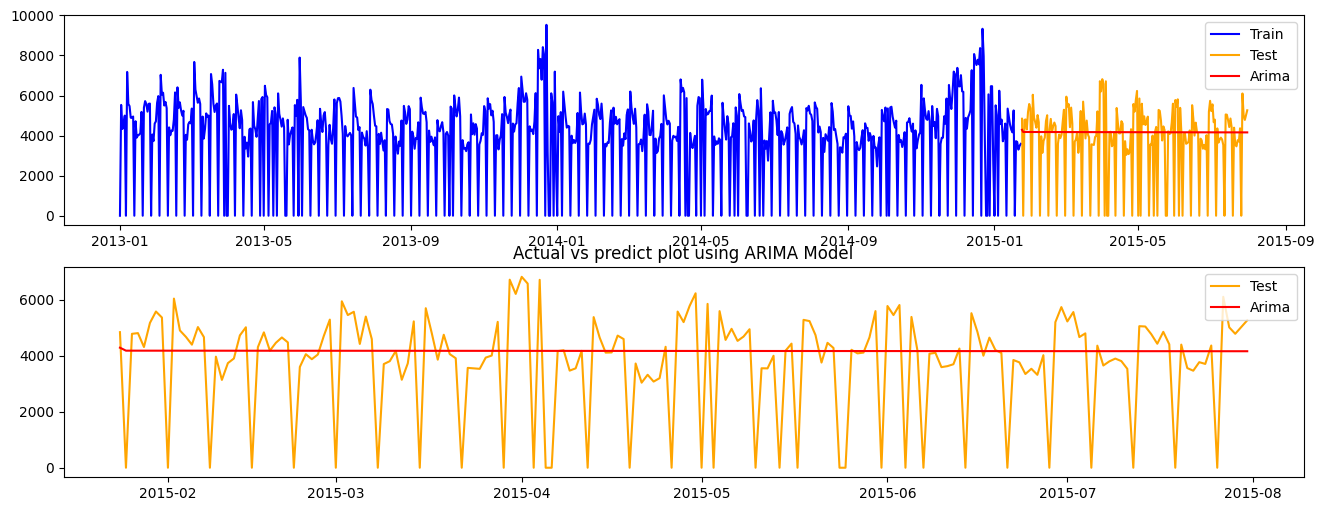

In [111]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(arima_forecast['ds'],arima_forecast['AutoARIMA'],label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(arima_forecast['ds'],arima_forecast['AutoARIMA'],label="Arima",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs predict plot using ARIMA Model')
plt.show()


#### Model Evaluation(RMSPE)

In [112]:
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

y_true=testdata['y']
y_pred=arima_forecast['AutoARIMA']
error=root_mean_squared_percentage_error(y_true,y_pred)
print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}")

Root Mean Squared Percentage Error (RMSPE): 0.5137


### SARIMAX

In [146]:
# fit model
SARIMAX_model = SARIMAX(train_data[["Sales"]], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
SARIMAX_model_fit = SARIMAX_model.fit()
SARIMAX_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  753
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6432.338
Date:                           Thu, 20 Jun 2024   AIC                          12874.676
Time:                                   22:36:56   BIC                          12897.797
Sample:                                        0   HQIC                         12883.583
                                           - 753                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.006    171.042      0.000       0.988       1.011
ma.L1         -0.9948      0.004   -260.595      0.000      -1.002      -0.987
ar.S.L7        1.0000   1.65e-06   6.05e+05      0.000       1.000       1.000
ma.S.L7       -0.9995      0.006   -167.713      0.000      -1.011      -0.988
sigma2      1.478e+06   1.05e-09    1.4e+15      0.000    1.48e+06    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                  55.14   Jarque-Bera (JB):               836.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.81
Prob(H) (two-sided):                  0.30   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.64e+29. Standard errors may be unstable.
"""

#### Forecast values

In [147]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)

In [148]:
SARIMAX_preds=pd.DataFrame(SARIMAX_preds).set_index(test_data['Date'])
SARIMAX_preds.head()

predicted_mean
Date                      
2015-01-24        0.000000
2015-01-25        0.000000
2015-01-26     2675.417207
2015-01-27     3213.928283
2015-01-28     3526.713635

#### Model Evaluation

In [149]:
start_index = test_data.index.min()
end_index = test_data.index.max()
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

#Predictions
SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)
print(f'RMSPE for SARIMAX on test:{root_mean_squared_percentage_error(SARIMAX_preds,test_data[["Sales"]])}')
# print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}") 

RMSPE for SARIMAX on test:0.6418558518989449


### ARIMAX

#### Forecast Exogenous Variables

In [119]:
Exogens_df = traindata[["ds","y","Open","Promo","SchoolHoliday","unique_id"]]
Exogens_df.columns = ["ds","y","Open","Promo","SchoolHoliday","unique_id"]
Exogens_df.head()
#Defining the models
models = [
    AutoARIMA()
]
sf = StatsForecast(df=Exogens_df,
                   models=models,
                   freq='D',  
                   n_jobs=-1,
                   fallback_model=SeasonalNaive(season_length=7))
sf.fit(Exogens_df)

StatsForecast(models=[AutoARIMA])

#### Forecast Exogens

In [120]:
def forecast_exog(exog_var_name, horizon):
    '''
    Inputs
    exog_var_name: Name of exogenous variable to be forecasted
    horizon: Time horizon of forecast
    
    Outputs
    forecasted_exog: Forecasted values of exogenous variable
    '''
    
    exog_df = Exogens_df[exog_var_name].reset_index()
    exog_df.columns = ["ds","y"]
    exog_df["unique_id"] = 1
    
    #Get forecast of realcons exogenous variable for next 4 quarters using a Drift method
    models = [RandomWalkWithDrift(alias="Drift")]
    sf_exog = StatsForecast(df=exog_df,
                       models=models,
                       freq='D', 
                       n_jobs=-1)
    
    forecasted_exog = sf_exog.forecast(horizon)["Drift"].values
    return(forecasted_exog)

In [121]:
Exogens_df.set_index('ds',inplace=True) #Set index as ds
forecasted_exog_df = pd.DataFrame() # create a DataFrame
forecasted_exog_df["ds"] = testdata["ds"] # In the final dataframe adding list of prediction dates
forecasted_exog_df["Open"] = forecast_exog("Open",189) # Forecasting exogens
forecasted_exog_df["Promo"] = forecast_exog("Promo",189) # Forecasting exogens
forecasted_exog_df["SchoolHoliday"] = forecast_exog("SchoolHoliday",189) # Forecasting exogens
forecasted_exog_df["unique_id"] = 1 # Adding unique id

In [122]:
#Exogenous dataframe format for Nixtla
forecasted_exog_df.head()

ds      Open  Promo  SchoolHoliday  unique_id
0 2015-01-24  1.001330    0.0      -0.001330          1
1 2015-01-25  1.002660    0.0      -0.002660          1
2 2015-01-26  1.003989    0.0      -0.003989          1
3 2015-01-27  1.005319    0.0      -0.005319          1
4 2015-01-28  1.006649    0.0      -0.006649          1

#### Forecast Values

In [123]:
#Get forecast
arima_forecast = sf.forecast(h=189, X_df = forecasted_exog_df, level = [95])
arima_forecast.head()

ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
unique_id                                                          
1         2015-01-24  3973.348877      2542.920166      5403.777832
1         2015-01-25  3973.277832      2474.068115      5472.487305
1         2015-01-26  4198.432617      2637.071045      5759.794434
1         2015-01-27  4204.678223      2580.331055      5829.024902
1         2015-01-28  4314.390137      2686.551514      5942.228516

#### Plot visualization of ARIMAX Model

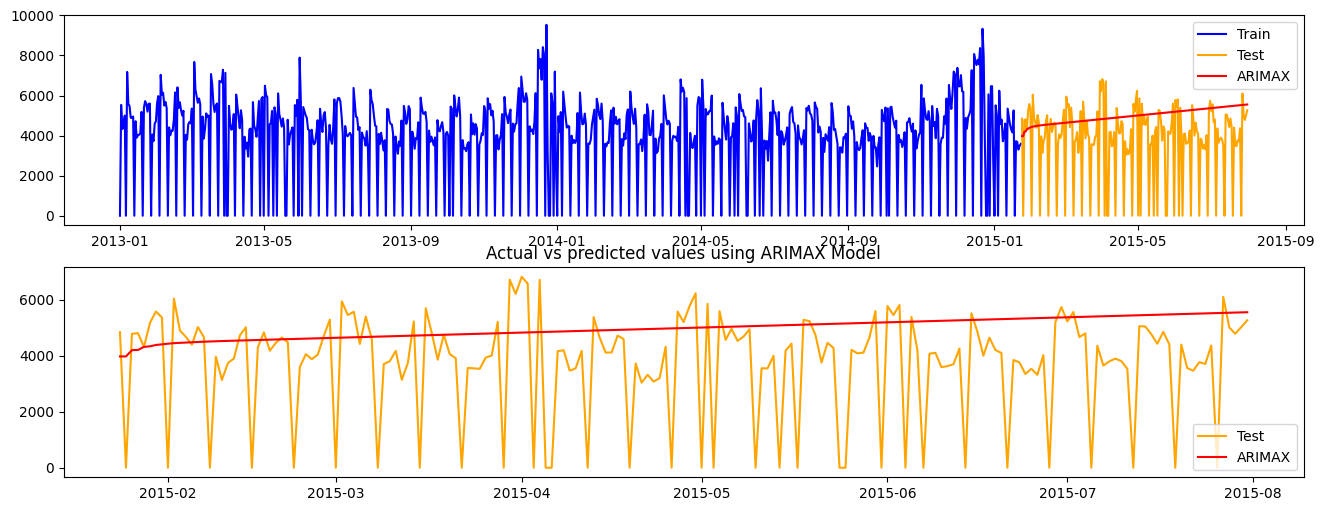

In [124]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(arima_forecast['ds'],arima_forecast['AutoARIMA'],label="ARIMAX",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(arima_forecast['ds'],arima_forecast['AutoARIMA'],label="ARIMAX",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs predicted values using ARIMAX Model')
plt.show()

#### Model Evaluation(RMSPE)

In [125]:
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

y_true=testdata['y']
y_pred=arima_forecast['AutoARIMA']
error=root_mean_squared_percentage_error(y_true,y_pred)
print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}")

Root Mean Squared Percentage Error (RMSPE): 0.6085


### Prophet

#### Univariate Method

##### Data preprocessing and forecast

In [126]:
#Format data for building Prophet model
prophet_df = traindata[["ds","y","unique_id"]]
prophet_df.columns = ["ds","y","unique_id"]
prophet_df.head()
#Fit model
prophet_model = Prophet(growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='additive').fit(prophet_df)
#Make forecasts
future = prophet_model.make_future_dataframe(periods=189, freq="d")
prophet_forecast_uni = prophet_model.predict(future)
prophet_forecast_uni[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

21:54:39 - cmdstanpy - INFO - Chain [1] start processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0 2013-01-01  4857.478291  3388.440992  6310.752608
1 2013-01-02  4635.732373  3041.246142  6158.898651
2 2013-01-03  4278.986392  2707.184292  5862.516327
3 2013-01-04  4790.388648  3187.328942  6340.241336
4 2013-01-05  5168.124079  3510.201699  6646.814984

##### Predicted values forecast

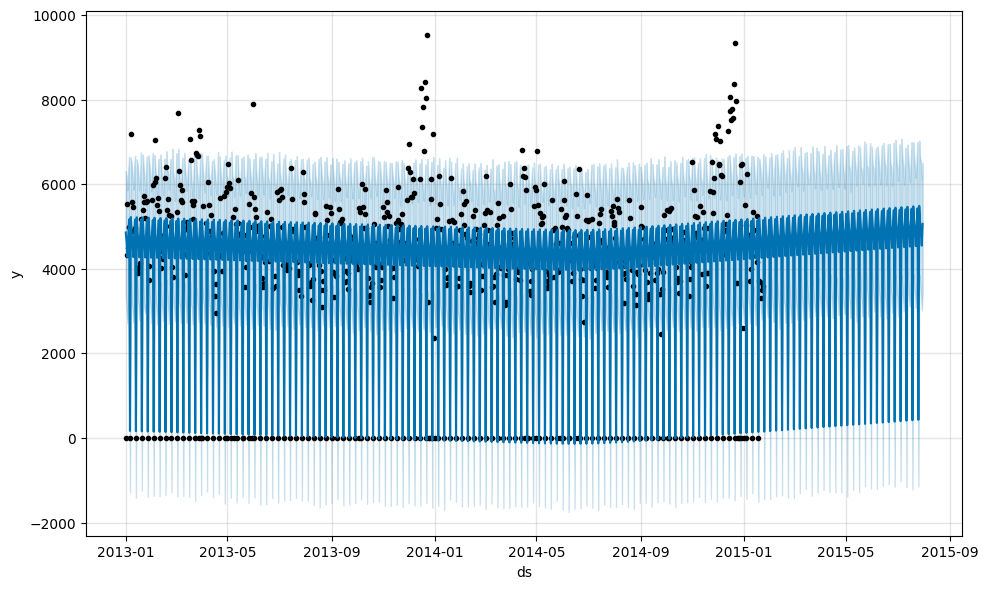

In [127]:
#Plot forecast
prophet_model.plot(prophet_forecast_uni)
plt.show()

##### Model Evaluation(RMSPE)

In [128]:
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

y_true=testdata['y']
y_pred=prophet_forecast_uni['yhat'][753:]
error=root_mean_squared_percentage_error(y_true,y_pred)
print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}")

Root Mean Squared Percentage Error (RMSPE): 0.3256


##### Plot Visualization using Prophet Univariate Model

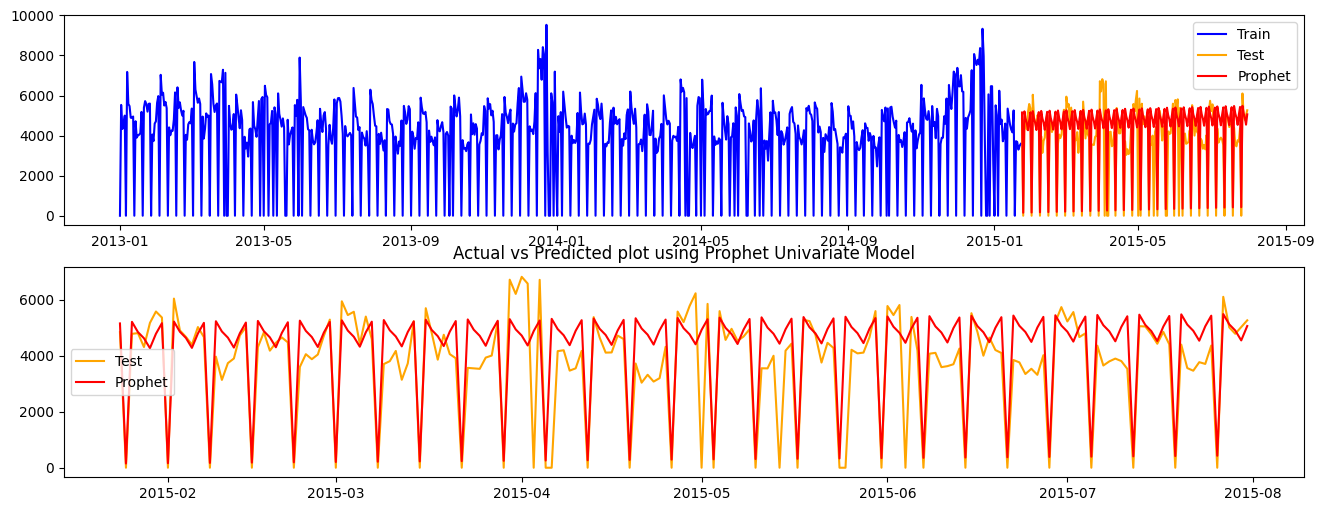

In [129]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(prophet_forecast_uni['ds'][753:],prophet_forecast_uni['yhat'][753:],label="Prophet",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(prophet_forecast_uni['ds'][753:],prophet_forecast_uni['yhat'][753:],label="Prophet",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted plot using Prophet Univariate Model')
plt.show()

#### Multivariate Method

##### Data preprocessing and fitting

In [130]:
#Format data for building Prophet model
prophet_df = traindata[["ds","y","Open","Promo","SchoolHoliday","unique_id"]]
prophet_df.columns = ["ds","y","Open","Promo","SchoolHoliday","unique_id"]
prophet_df
#Initialize model
prophet_model = Prophet(growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='additive')
prophet_model.add_regressor("Open")
prophet_model.add_regressor("Promo")
prophet_model.add_regressor("SchoolHoliday")
#Fit the model
prophet_model.fit(prophet_df)

21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] done processing


##### Forecast Exogens

In [131]:
def forecast_exog(exog_var_name, horizon):
    '''
    Inputs
    exog_var_name: Name of exogenous variable to be forecasted
    horizon: Time horizon of forecast
    
    Outputs
    forecasted_exog: Forecasted values of exogenous variable
    '''
    
    exog_df = prophet_df[exog_var_name].reset_index()
    exog_df.columns = ["ds","y"]
    exog_df["unique_id"] = 1
    
    #Get forecast of realcons exogenous variable for next 4 quarters using a Drift method
    models = [RandomWalkWithDrift(alias="Drift")]
    sf_exog = StatsForecast(df=exog_df,
                       models=models,
                       freq='D', # quarterly frequency
                       n_jobs=-1)
    
    forecasted_exog = sf_exog.forecast(horizon)["Drift"].values
    return(forecasted_exog)

##### Exogens Dataframe & Updating values

In [132]:
future = prophet_model.make_future_dataframe(periods=189, freq="D")
#Added historical actual data of exogenous variables
future.loc[future["ds"] <= "2015-01-24",["Open","Promo","SchoolHoliday"]] = prophet_df.loc[prophet_df["ds"] <= "2015-01-24",["Open","Promo","SchoolHoliday"]]
future

ds  Open  Promo  SchoolHoliday
0   2013-01-01   0.0    0.0            1.0
1   2013-01-02   1.0    0.0            1.0
2   2013-01-03   1.0    0.0            1.0
3   2013-01-04   1.0    0.0            1.0
4   2013-01-05   1.0    0.0            1.0
..         ...   ...    ...            ...
937 2015-07-27   NaN    NaN            NaN
938 2015-07-28   NaN    NaN            NaN
939 2015-07-29   NaN    NaN            NaN
940 2015-07-30   NaN    NaN            NaN
941 2015-07-31   NaN    NaN            NaN

[942 rows x 4 columns]

##### Forecast Values

In [133]:
prophet_df.set_index('ds',inplace=True)
forecasted_exog_df = pd.DataFrame()
forecasted_exog_df["ds"] = testdata['ds'] #Set index as ds
forecasted_exog_df["Open"] = forecast_exog("Open",189) #forecasting exogens
forecasted_exog_df["Promo"] = forecast_exog("Promo",189) #forecasting exogens
forecasted_exog_df["SchoolHoliday"] = forecast_exog("SchoolHoliday",189) #forecasting exogens
forecasted_exog_df

ds      Open  Promo  SchoolHoliday
0   2015-01-24  1.001330    0.0      -0.001330
1   2015-01-25  1.002660    0.0      -0.002660
2   2015-01-26  1.003989    0.0      -0.003989
3   2015-01-27  1.005319    0.0      -0.005319
4   2015-01-28  1.006649    0.0      -0.006649
..         ...       ...    ...            ...
184 2015-07-27  1.246011    0.0      -0.246011
185 2015-07-28  1.247340    0.0      -0.247340
186 2015-07-29  1.248670    0.0      -0.248670
187 2015-07-30  1.250000    0.0      -0.250000
188 2015-07-31  1.251330    0.0      -0.251330

[189 rows x 4 columns]

In [134]:
future.loc[future["ds"] > "2015-01-23",["Open","Promo","SchoolHoliday"]] =forecasted_exog_df.loc[:,["Open","Promo","SchoolHoliday"]].values
#Make forecasts
prophet_forecast_multi = prophet_model.predict(future)
prophet_forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
937 2015-07-27  6966.591121  6037.168287  7857.558752
938 2015-07-28  6486.842093  5525.400813  7450.422439
939 2015-07-29  6359.575808  5388.834024  7291.111257
940 2015-07-30  6263.733970  5304.159691  7242.624812
941 2015-07-31  6578.132340  5640.851257  7559.481536

#### Plot Visualization

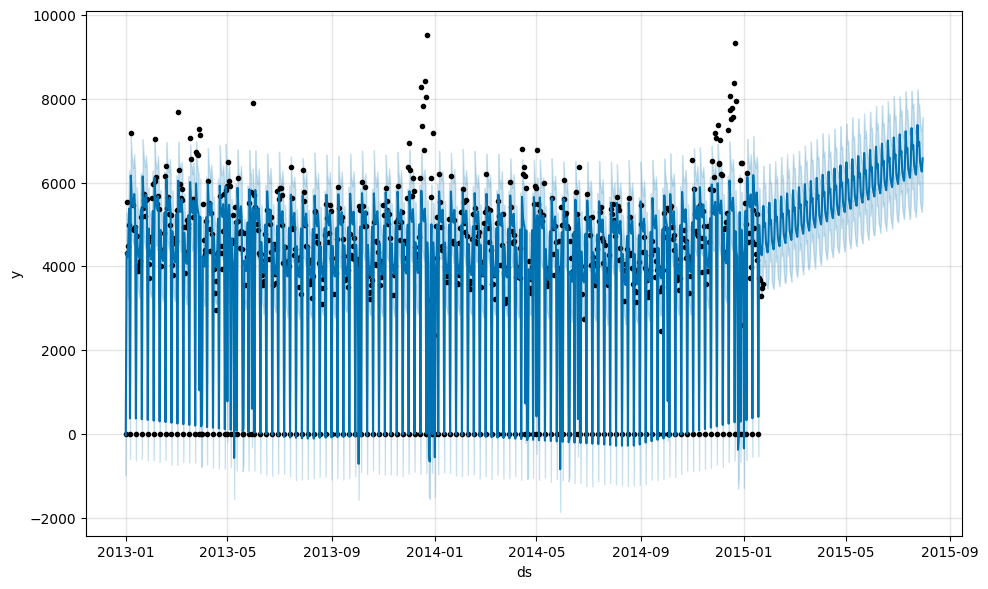

In [135]:
#Plot forecast (multivariate)
prophet_model.plot(prophet_forecast_multi)
plt.show()

#### Model Evaluation

In [136]:
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

y_true=testdata['y']
y_pred=prophet_forecast_multi['yhat'][753:]
error=root_mean_squared_percentage_error(y_true,y_pred)
print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}")

Root Mean Squared Percentage Error (RMSPE): 0.7618


#### Model Visualization using Prophet multivariate model

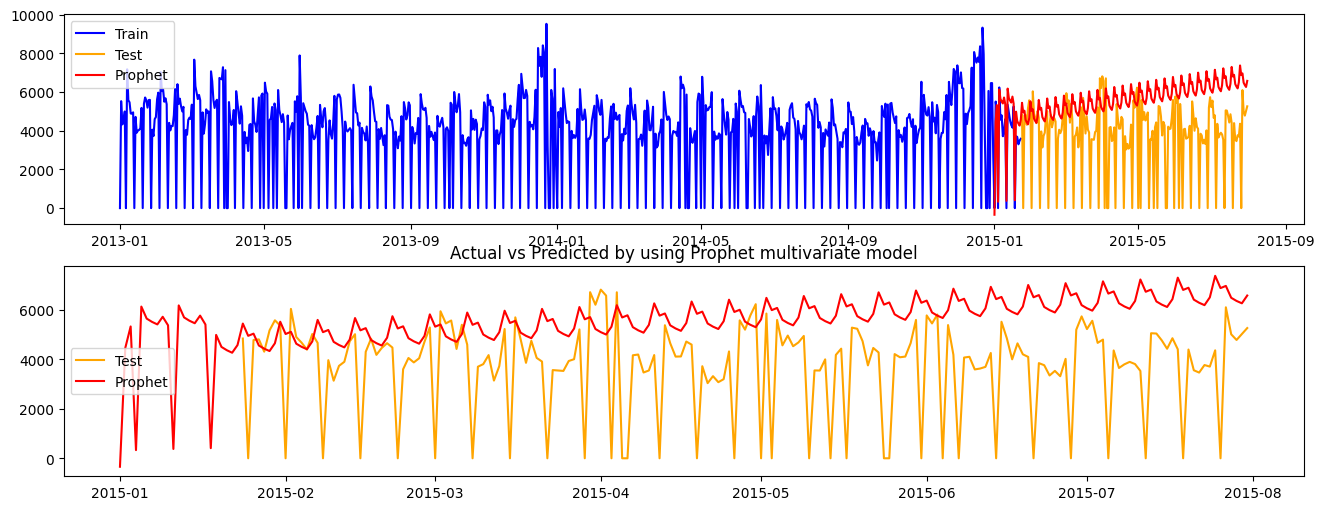

In [137]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(traindata["ds"],traindata["y"], label='Train',color='blue')
axes[0].plot(testdata["ds"],testdata["y"], label='Test',color='orange')

axes[0].plot(prophet_forecast_multi['ds'][730:],prophet_forecast_multi['yhat'][730:],label="Prophet",color='red')
axes[0].legend(loc='best')

axes[1].plot(testdata["ds"],testdata["y"], label='Test',color='orange')
axes[1].plot(prophet_forecast_multi['ds'][730:],prophet_forecast_multi['yhat'][730:],label="Prophet",color='red')
axes[1].legend(loc='best')
plt.title('Actual vs Predicted by using Prophet multivariate model')
plt.show()

### Prophet Multivariate single exogen

#### Data Preprocessing and taking promo as exogen

In [174]:
#Format data for building Prophet model
prophet_df = traindata[["ds","y","Promo","unique_id"]]
prophet_df.columns = ["ds","y","Promo","unique_id"]
prophet_df
#Initialize model
prophet_model = Prophet(growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='additive')
prophet_model.add_regressor("Promo")
#Fit the model
prophet_model.fit(prophet_df)

23:05:09 - cmdstanpy - INFO - Chain [1] start processing
23:05:09 - cmdstanpy - INFO - Chain [1] done processing


#### Forecast Exogen

In [175]:
def forecast_exog(exog_var_name, horizon):
    '''
    Inputs
    exog_var_name: Name of exogenous variable to be forecasted
    horizon: Time horizon of forecast
    
    Outputs
    forecasted_exog: Forecasted values of exogenous variable
    '''
    
    exog_df = prophet_df[exog_var_name].reset_index()
    exog_df.columns = ["ds","y"]
    exog_df["unique_id"] = 1
    
    #Get forecast of realcons exogenous variable for next 4 quarters using a Drift method
    models = [RandomWalkWithDrift(alias="Drift")]
    sf_exog = StatsForecast(df=exog_df,
                       models=models,
                       freq='D', # quarterly frequency
                       n_jobs=-1)
    
    forecasted_exog = sf_exog.forecast(horizon)["Drift"].values
    return(forecasted_exog)

In [176]:
future = prophet_model.make_future_dataframe(periods=189, freq="D")
#Added historical actual data of exogenous variables
future.loc[future["ds"] <= "2015-01-24",["Promo"]] = prophet_df.loc[prophet_df["ds"] <= "2015-01-24",["Promo"]]
prophet_df.set_index('ds',inplace=True)
forecasted_exog_df = pd.DataFrame()
forecasted_exog_df["ds"] = testdata['ds'] #Set index as ds
forecasted_exog_df["Promo"] = forecast_exog("Promo",189) #forecasting exogens
forecasted_exog_df

ds  Promo
0   2015-01-24    0.0
1   2015-01-25    0.0
2   2015-01-26    0.0
3   2015-01-27    0.0
4   2015-01-28    0.0
..         ...    ...
184 2015-07-27    0.0
185 2015-07-28    0.0
186 2015-07-29    0.0
187 2015-07-30    0.0
188 2015-07-31    0.0

[189 rows x 2 columns]

#### Forecast Sales

In [177]:
future.loc[future["ds"] > "2015-01-23",["Promo"]] =forecasted_exog_df.loc[:,["Promo"]].values
#Make forecasts
prophet_forecast_multi = prophet_model.predict(future)
prophet_forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
937 2015-07-27  4866.069651  3526.406478  6178.797788
938 2015-07-28  4506.779372  3139.850377  5835.170297
939 2015-07-29  4287.647164  3007.410516  5676.119476
940 2015-07-30  3933.542006  2712.034681  5367.629021
941 2015-07-31  4447.371547  2933.489433  5756.884593

#### Plot Visualization

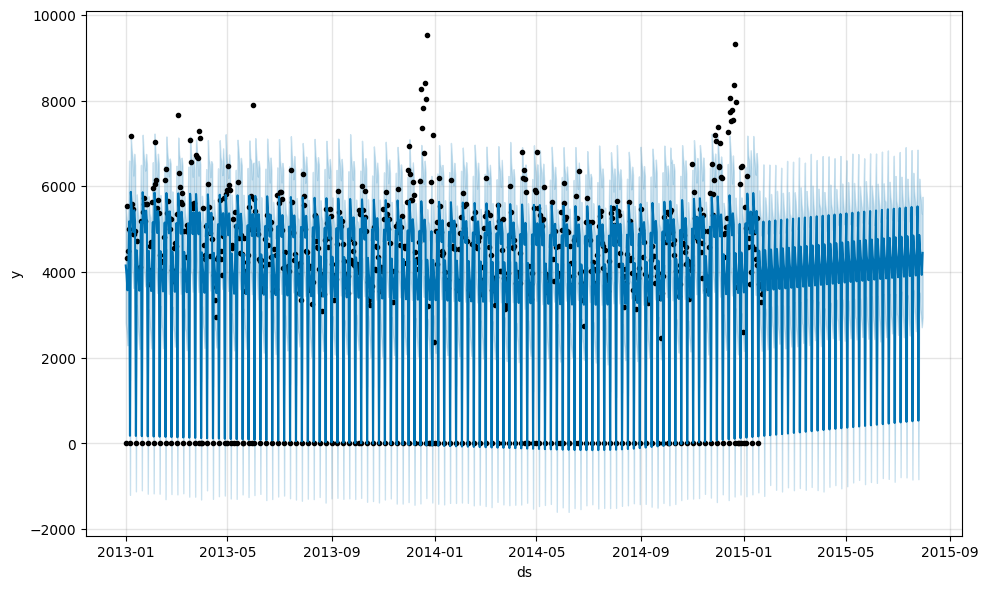

In [178]:
#Plot forecast (multivariate)
prophet_model.plot(prophet_forecast_multi)
plt.show()

### Model Evaluation

In [163]:
def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).

    Parameters:
    - y_true (array-like): Array of true values.
    - y_pred (array-like): Array of predicted values.

    Returns:
    - float: RMSPE value.
    """

y_true=testdata['y']
y_pred=prophet_forecast_multi['yhat'][753:]
error=root_mean_squared_percentage_error(y_true,y_pred)
print(f"Root Mean Squared Percentage Error (RMSPE): {error:.4f}")

Root Mean Squared Percentage Error (RMSPE): 0.3010


## Model Results

In [181]:
import prettytable
from prettytable import PrettyTable

table_univariate = PrettyTable()
table_univariate.field_names = ["Model", "Metric", "Error"]
table_univariate.add_row(["Seasonal Naive", "RMSPE", 0.34])
table_univariate.add_row(["Naive", "RMSPE", 0.5])
table_univariate.add_row(["SESOpt", "RMSPE", 0.5])
table_univariate.add_row(["Theta", "RMSPE", 0.5])
table_univariate.add_row(["Average", "RMSPE", 0.51])
table_univariate.add_row(["Drift", "RMSPE", 0.51])
table_univariate.add_row(["Holt", "RMSPE", 0.51])

table_Multivariate = PrettyTable()
table_Multivariate.field_names = ["Model", "Metric", "Error"]
table_Multivariate.add_row(["Prophet Multivariate(single exogen)", "RMSPE", 0.30])
table_Multivariate.add_row(["Prophet Univariate", "RMSPE", 0.32])
table_Multivariate.add_row(["ARIMAX", "RMSPE", 0.60])
table_Multivariate.add_row(["SARIMAX", "RMSPE", 0.64])
table_Multivariate.add_row(["Prophet Multivariate", "RMSPE", 0.76])
table_Multivariate.add_row(["ARIMA", "RMSPE", 0.86])

print("Univariate Methods\n")
print(table_univariate)
print("Multivariate Methods\n")
print(table_Multivariate)

Univariate Methods

+----------------+--------+-------+
|     Model      | Metric | Error |
+----------------+--------+-------+
| Seasonal Naive | RMSPE  |  0.34 |
|     Naive      | RMSPE  |  0.5  |
|     SESOpt     | RMSPE  |  0.5  |
|     Theta      | RMSPE  |  0.5  |
|    Average     | RMSPE  |  0.51 |
|     Drift      | RMSPE  |  0.51 |
|      Holt      | RMSPE  |  0.51 |
+----------------+--------+-------+
Multivariate Methods

+-------------------------------------+--------+-------+
|                Model                | Metric | Error |
+-------------------------------------+--------+-------+
| Prophet Multivariate(single exogen) | RMSPE  |  0.3  |
|          Prophet Univariate         | RMSPE  |  0.32 |
|                ARIMAX               | RMSPE  |  0.6  |
|               SARIMAX               | RMSPE  |  0.64 |
|         Prophet Multivariate        | RMSPE  |  0.76 |
|                ARIMA                | RMSPE  |  0.86 |
+-------------------------------------+--------+-

**we can conclude that from univariate Methods Seasonal Naive performing best & from Multivariate Methods Prophet Multivariate single exogen and Prophet Univariate performing best**